# Import Libraries and Dataset

In [144]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle

from plotly import graph_objs as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

np.random.seed(0)

keys = ['A', 'D', 'S']
csv_files = [f for f in os.listdir() if f.split('.')[-1] in ['csv']]
csv_files

['asthma_dataset.csv', 'diabetes_data.csv', 'stroke_data.csv']

In [145]:
data_dict = dict()
for k, data in zip(keys, csv_files):
    data_dict[k] = pd.read_csv(data)

# Data Understanding

In [146]:
data_dict['A'].head()

,VAX_TYPE,AGE_YRS,SEX,SLEEPING_PROB,CHEST_TIGHTNESS,BREATH,COUGH,ALLERGY,WHEEZING,ASTHMA
0,HEPA,1.5,M,False,False,False,False,False,False,False
1,RV5,28.0,F,False,True,True,True,False,True,True
2,FLU3,53.0,F,False,False,False,False,False,False,False
3,HEP,69.0,M,False,False,False,False,False,False,False
4,HEPA,24.0,F,False,False,True,True,False,True,True


In [147]:
data_dict['A'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309226 entries, 0 to 309225
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAX_TYPE         309226 non-null  object 
 1   AGE_YRS          245860 non-null  float64
 2   SEX              309226 non-null  object 
 3   SLEEPING_PROB    309226 non-null  bool   
 4   CHEST_TIGHTNESS  309226 non-null  bool   
 5   BREATH           309226 non-null  bool   
 6   COUGH            309226 non-null  bool   
 7   ALLERGY          309226 non-null  bool   
 8   WHEEZING         309226 non-null  bool   
 9   ASTHMA           309226 non-null  bool   
dtypes: bool(7), float64(1), object(2)
memory usage: 9.1+ MB


In [148]:
data_dict['D'].head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
data_dict['D'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

In [150]:
data_dict['S'].head()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1


In [151]:
data_dict['S'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


# Data Pre-processing

## Data Cleaning


In [152]:
data_dict['A'] = data_dict['A'].iloc[:,data_dict['A'].columns!="VAX_TYPE"] #Remove unnecessary variable - VAX_TYPE
data_dict['A'].head()

,AGE_YRS,SEX,SLEEPING_PROB,CHEST_TIGHTNESS,BREATH,COUGH,ALLERGY,WHEEZING,ASTHMA
0,1.5,M,False,False,False,False,False,False,False
1,28.0,F,False,True,True,True,False,True,True
2,53.0,F,False,False,False,False,False,False,False
3,69.0,M,False,False,False,False,False,False,False
4,24.0,F,False,False,True,True,False,True,True


## Find all unique value for each class

In [153]:
# To identify the unique values of each column
def show_unique_values(df: pd.DataFrame): 

    data = [] # Initialize an empty list to store the data

    # Iterate over each column in the DataFrame
    for col in df.columns: 
        unique_value = np.unique(df[col]).tolist() # Find the unique values in the current column using np.unique() function
        
        # Convert the unique values to a list
        temp_str = ""

        data.append([col, len(unique_value), ", ".join(str(value) for value in unique_value)])
    df_temp = pd.DataFrame(data, columns=["Columns Name", "Num of unique value", "Unique Value"]) # Create a DataFrame using the data list
    pd.options.display.max_colwidth = 50 # Set the maximum width of column values to 50 characters
    
    return df_temp # Return the DataFrame with unique values

# Function to check for null values in a DataFrame and handle them
def check_null(data: pd.DataFrame, solver: str=None):
    if solver not in ['remove', 'replace', None]:
        raise ValueError(f"The argument only takes 'remove' or 'replace' but found '{solver}'.")
    
    contain_null = data.isnull().any().any() # Check if the DataFrame contains any null values by using the isnull() and any() functions
    if not contain_null: 
        print("The dataset does not contain any null values.")
        return 
    
    # Find the columns with missing values and the number of missing values in each column
    # Store the results as tuples in the col_miss list
    col_miss = [(col,data[col].isnull().sum()) for col in data.columns if data[col].isnull().sum() > 0]
    print("Columns with missing values and the number of missing value: ", col_miss)
    if not solver:
        pass
    elif solver == 'remove':
        return data.dropna()
    elif solver == 'replace':
        for col,_ in col_miss:
            mean = data[col].mean() # Calculate the mean of the column with missing values    
            data.loc[:,col].fillna(mean, inplace=True) # Replace the missing values with the mean value in the column using fillna() function
            
        return data # Return the modified DataFrame after replacing missing values
    
    

In [154]:
# Drop null values
show_unique_values(data_dict['A'])

,Columns Name,Num of unique value,Unique Value
0,AGE_YRS,344,"0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,..."
1,SEX,3,"F, M, U"
2,SLEEPING_PROB,2,"False, True"
3,CHEST_TIGHTNESS,2,"False, True"
4,BREATH,2,"False, True"
5,COUGH,2,"False, True"
6,ALLERGY,2,"False, True"
7,WHEEZING,2,"False, True"
8,ASTHMA,2,"False, True"


In [155]:
# Drop 'U' category in 'SEX' column
data_dict['A'] = data_dict['A'].drop(data_dict['A'][data_dict['A']['SEX'] == 'U'].index)
# Drop null values
show_unique_values(data_dict['A'].dropna())

,Columns Name,Num of unique value,Unique Value
0,AGE_YRS,335,"0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,..."
1,SEX,2,"F, M"
2,SLEEPING_PROB,2,"False, True"
3,CHEST_TIGHTNESS,2,"False, True"
4,BREATH,2,"False, True"
5,COUGH,2,"False, True"
6,ALLERGY,2,"False, True"
7,WHEEZING,2,"False, True"
8,ASTHMA,2,"False, True"


In [156]:
# Drop null values
show_unique_values(data_dict['D'])

,Columns Name,Num of unique value,Unique Value
0,Age,13,"1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1..."
1,Sex,2,"0.0, 1.0"
2,HighChol,2,"0.0, 1.0"
3,CholCheck,2,"0.0, 1.0"
4,BMI,80,"12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0..."
5,Smoker,2,"0.0, 1.0"
6,HeartDiseaseorAttack,2,"0.0, 1.0"
7,PhysActivity,2,"0.0, 1.0"
8,Fruits,2,"0.0, 1.0"
9,Veggies,2,"0.0, 1.0"


In [157]:
# Drop null values
show_unique_values(data_dict['D'].dropna())

,Columns Name,Num of unique value,Unique Value
0,Age,13,"1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1..."
1,Sex,2,"0.0, 1.0"
2,HighChol,2,"0.0, 1.0"
3,CholCheck,2,"0.0, 1.0"
4,BMI,80,"12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0..."
5,Smoker,2,"0.0, 1.0"
6,HeartDiseaseorAttack,2,"0.0, 1.0"
7,PhysActivity,2,"0.0, 1.0"
8,Fruits,2,"0.0, 1.0"
9,Veggies,2,"0.0, 1.0"


In [158]:
# Remove Negative Value
data_dict['S'] = data_dict['S'][data_dict['S']['age'] >= 0]

negative_val = data_dict['S']['age'][data_dict['S']['age'] < 0]

# Drop null values
show_unique_values(data_dict['S'].dropna())

,Columns Name,Num of unique value,Unique Value
0,sex,2,"0.0, 1.0"
1,age,104,"0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9..."
2,hypertension,2,"0, 1"
3,heart_disease,2,"0, 1"
4,ever_married,2,"0, 1"
5,work_type,5,"0, 1, 2, 3, 4"
6,Residence_type,2,"0, 1"
7,avg_glucose_level,2903,"55.12, 55.22, 55.25, 55.27, 55.32, 55.34, 55.4..."
8,bmi,370,"11.5, 14.1, 15.0, 15.3, 15.4, 15.7, 16.0, 16.1..."
9,smoking_status,2,"0, 1"


In [159]:
data_dict['A'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 251676 entries, 0 to 309225
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AGE_YRS          235396 non-null  float64
 1   SEX              251676 non-null  object 
 2   SLEEPING_PROB    251676 non-null  bool   
 3   CHEST_TIGHTNESS  251676 non-null  bool   
 4   BREATH           251676 non-null  bool   
 5   COUGH            251676 non-null  bool   
 6   ALLERGY          251676 non-null  bool   
 7   WHEEZING         251676 non-null  bool   
 8   ASTHMA           251676 non-null  bool   
dtypes: bool(7), float64(1), object(1)
memory usage: 7.4+ MB


In [160]:
data_dict['D'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

In [161]:
data_dict['S'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 40852 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40849 non-null  float64
 1   age                40852 non-null  float64
 2   hypertension       40852 non-null  int64  
 3   heart_disease      40852 non-null  int64  
 4   ever_married       40852 non-null  int64  
 5   work_type          40852 non-null  int64  
 6   Residence_type     40852 non-null  int64  
 7   avg_glucose_level  40852 non-null  float64
 8   bmi                40852 non-null  float64
 9   smoking_status     40852 non-null  int64  
 10  stroke             40852 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.7 MB


In [162]:
# Identify columns in 'data_dict['A']' with missing values and count the number of missing values in each column
col_miss_asthma = [(col,data_dict['A'][col].isna().sum()) for col in data_dict['A'].columns if data_dict['A'][col].isna().sum() > 0]
col_miss_asthma

[('AGE_YRS', 16280)]

In [163]:
#Drop rows in 'data_dict['A']' where any column in 'col_miss_asthma' has missing values
data_dict['A'].dropna(subset=[col for col, _ in col_miss_asthma], inplace=True)

In [164]:
# Drop rows in 'data_dict['D']' where any column in 'col_miss_asthma' has missing values
col_miss_diabetes = [(col,data_dict['D'][col].isna().sum()) for col in data_dict['D'].columns if data_dict['D'][col].isna().sum() > 0]
col_miss_diabetes

[]

In [165]:
# Drop rows in 'data_dict['S']' where any column in 'col_miss_asthma' has missing values
col_miss_stroke = [(col,data_dict['S'][col].isna().sum()) for col in data_dict['S'].columns if data_dict['S'][col].isna().sum() > 0]
col_miss_stroke

[('sex', 3)]

In [166]:
#Drop rows in 'data_dict['S']' where any column in 'col_miss_asthma' has missing values
data_dict['S'].dropna(subset=[col for col, _ in col_miss_stroke], inplace=True)

In [167]:
data_dict['A']['ASTHMA'].value_counts()

ASTHMA
False    219417
True      15979
Name: count, dtype: int64

In [168]:
data_dict['D']['Diabetes'].value_counts()

Diabetes
0.0    35346
1.0    35346
Name: count, dtype: int64

In [169]:
data_dict['S']['stroke'].value_counts()

stroke
0    20447
1    20402
Name: count, dtype: int64

## Get the categorical and numerical columns name

In [170]:
numerical_a = [x for x in data_dict['A'].columns if len(data_dict['A'][x].unique()) > 6]    # Define categorical variables (columns)
categorical_a = list(set(data_dict['A'].columns) - set(numerical_a))  # Define numerical variables (columns)

print(f"{len(numerical_a)} Numerical variables (columns) are: {np.sort(numerical_a)}\n")
print(f"{len(categorical_a)} Categorical variables (columns) are: {np.sort(categorical_a)}")

1 Numerical variables (columns) are: ['AGE_YRS']

8 Categorical variables (columns) are: ['ALLERGY' 'ASTHMA' 'BREATH' 'CHEST_TIGHTNESS' 'COUGH' 'SEX'
 'SLEEPING_PROB' 'WHEEZING']


In [171]:
numerical_d = [x for x in data_dict['D'].columns if len(data_dict['D'][x].unique()) > 13]    # Define categorical variables (columns)
categorical_d = list(set(data_dict['D'].columns) - set(numerical_d))  # Define numerical variables (columns)

print(f"{len(numerical_d)} Numerical variables (columns) are: {np.sort(numerical_d)}\n")
print(f"{len(categorical_d)} Categorical variables (columns) are: {np.sort(categorical_d)}")

3 Numerical variables (columns) are: ['BMI' 'MentHlth' 'PhysHlth']

15 Categorical variables (columns) are: ['Age' 'CholCheck' 'Diabetes' 'DiffWalk' 'Fruits' 'GenHlth'
 'HeartDiseaseorAttack' 'HighBP' 'HighChol' 'HvyAlcoholConsump'
 'PhysActivity' 'Sex' 'Smoker' 'Stroke' 'Veggies']


In [172]:
numerical_s = [x for x in data_dict['S'].columns if len(data_dict['S'][x].unique()) > 6]    # Define categorical variables (columns)
categorical_s = list(set(data_dict['S'].columns) - set(numerical_s))  # Define numerical variables (columns)

print(f"{len(numerical_s)} Numerical variables (columns) are: {np.sort(numerical_s)}\n")
print(f"{len(categorical_s)} Categorical variables (columns) are: {np.sort(categorical_s)}")

3 Numerical variables (columns) are: ['age' 'avg_glucose_level' 'bmi']

8 Categorical variables (columns) are: ['Residence_type' 'ever_married' 'heart_disease' 'hypertension' 'sex'
 'smoking_status' 'stroke' 'work_type']


# Exploratory Data Analysis (EDA)

## Boxplot for numerical variable

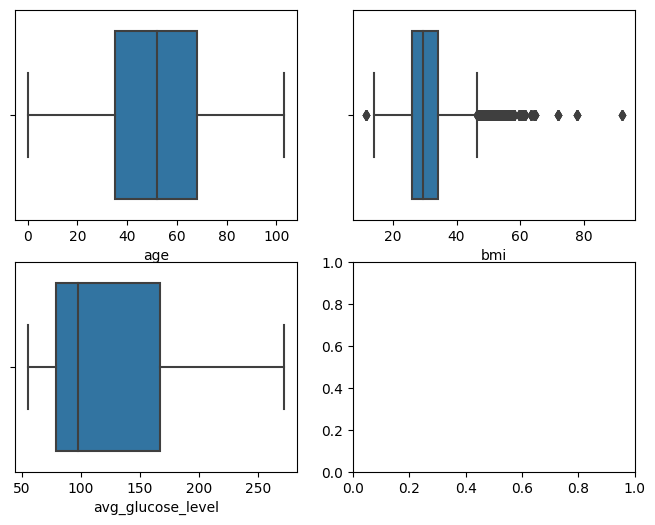

In [173]:
_, ax = plt.subplots(2, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_s):
    sns.boxplot(data=data_dict['S'], x=feature, ax = ax[i%2, i//2])

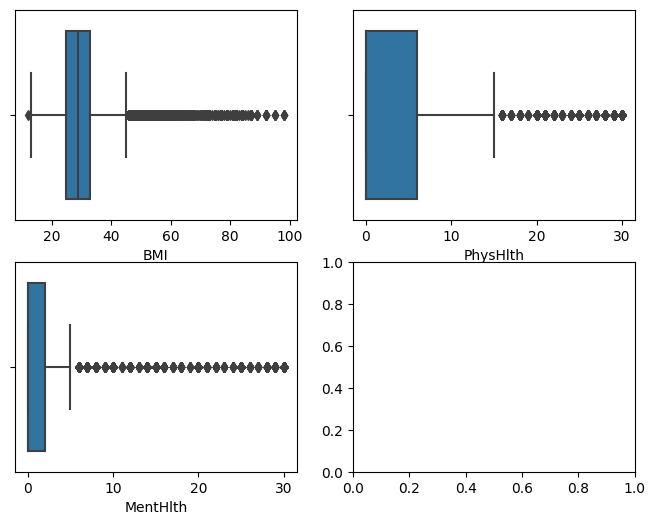

In [174]:
_, ax = plt.subplots(2, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_d):
    sns.boxplot(data=data_dict['D'], x=feature, ax = ax[i%2, i//2])

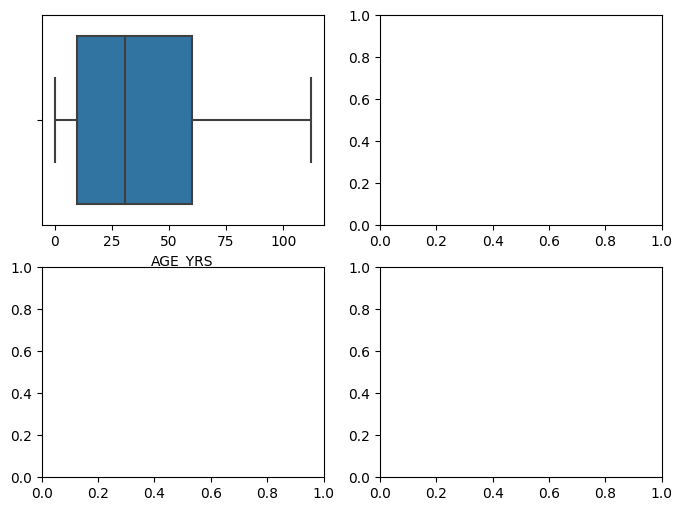

In [175]:
_, ax = plt.subplots(2, 2, figsize=(8, 6))

for i, feature in enumerate(numerical_a):
    sns.boxplot(data=data_dict['A'], x=feature, ax = ax[i%2, i//2])

## Kernel Density Estimate for numerical variable

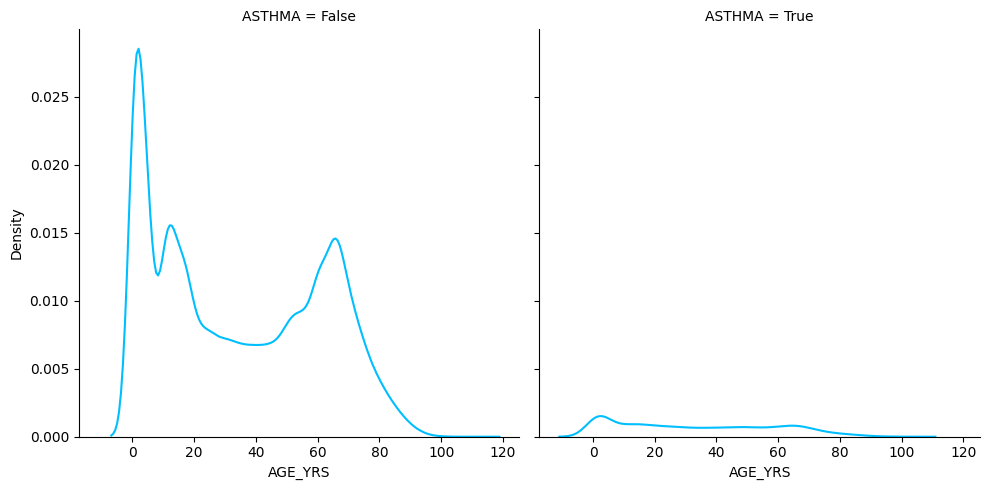

In [176]:
for feature in numerical_a: # KDE distribution of numerical feature
    sns.displot(x = feature,col='ASTHMA',data = data_dict['A'], kind="kde" ,color = 'deepskyblue')

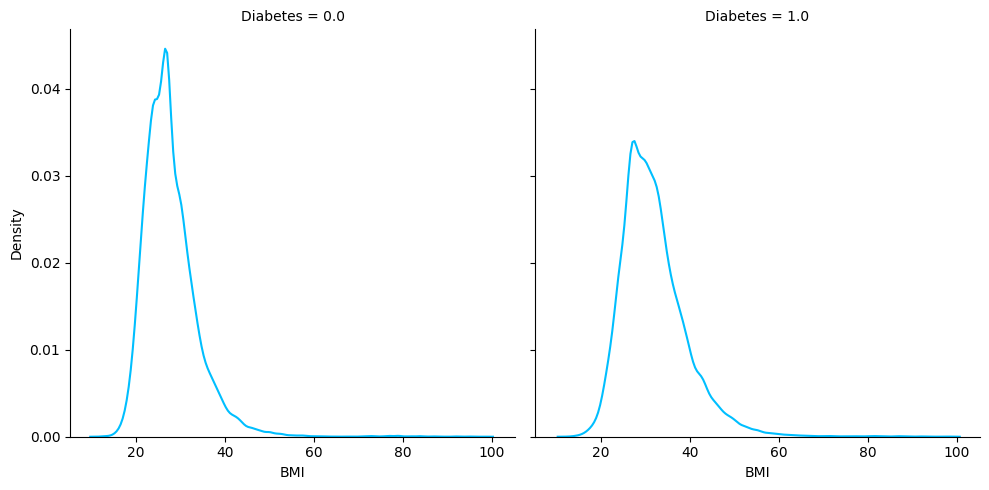

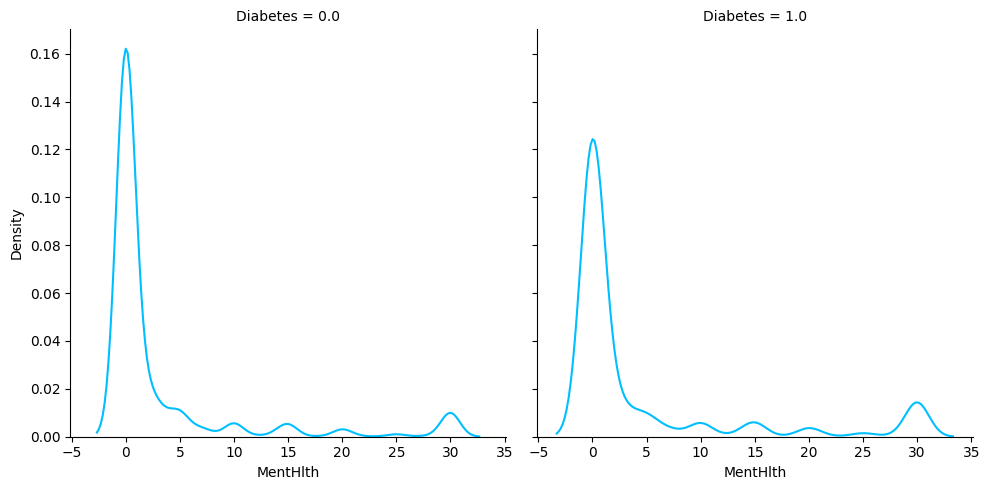

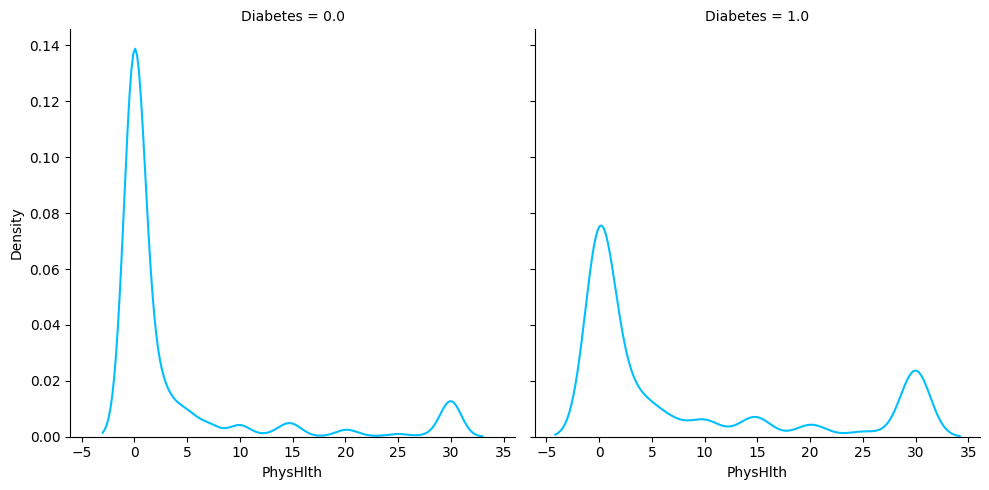

In [177]:
for feature in numerical_d: # KDE distribution of numerical feature
    sns.displot(x = feature,col='Diabetes',data = data_dict['D'], kind="kde" ,color = 'deepskyblue')

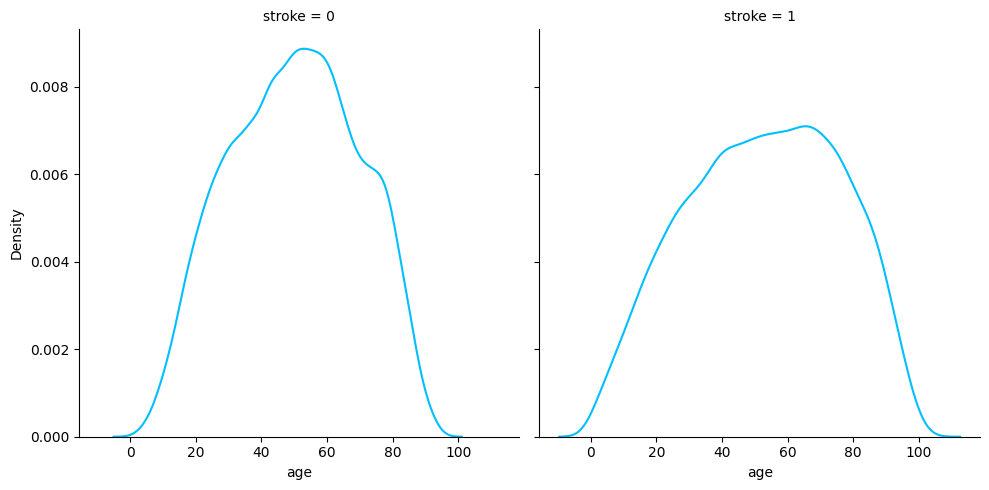

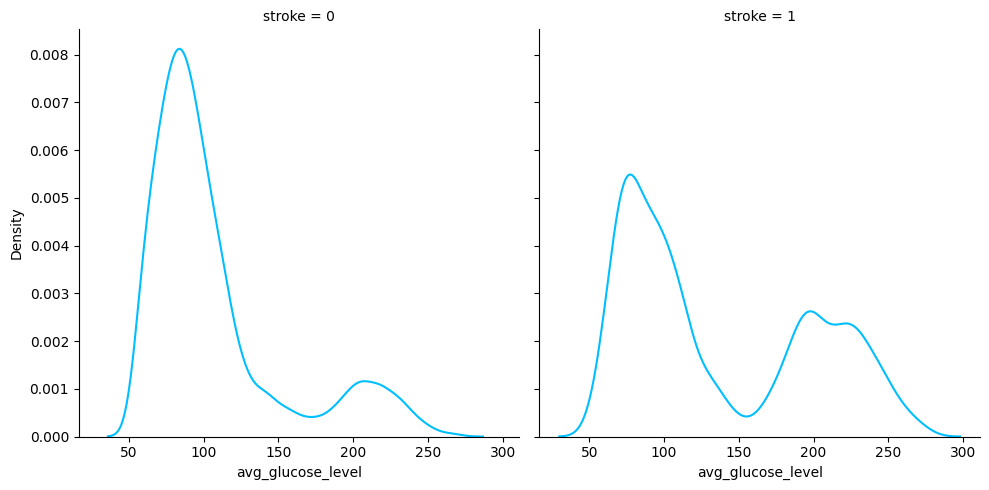

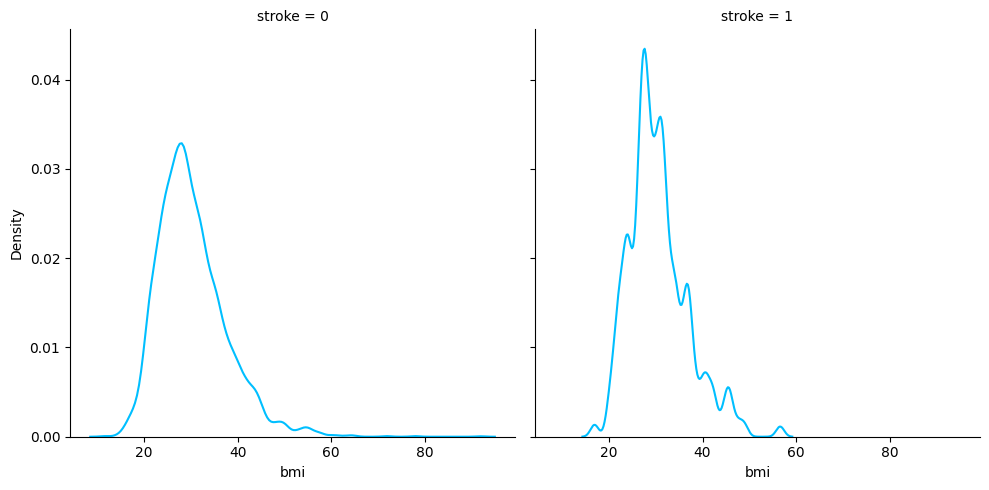

In [178]:
for feature in numerical_s: # KDE distribution of numerical feature
    sns.displot(x = feature,col='stroke',data = data_dict['S'], kind="kde" ,color = 'deepskyblue')

## Histogram and Bivariate bar plot for categorical variables

In [179]:
def bivariate_bar_plot_for_a(n_cols, columns, figsize=(12,8)):
    n_rows = int(np.ceil(len(columns) / n_cols))
    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = figsize)
    plt.suptitle('Asthma by categorical features')

    for i, col in enumerate(columns):
        x = sns.countplot(data=data_dict['A'][categorical_a], x=col, hue='ASTHMA', palette = ['deepskyblue','crimson'], ax=ax[i//n_cols, i%n_cols])
        for z in x.patches:
          x.annotate('{:.1f}'.format((z.get_height()/data_dict['A'][categorical_a].shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [180]:
n_cols = 3
n_rows = n_rows = int(np.ceil(len(categorical_a.copy()) / n_cols))

"""Histogram using plotly"""
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=tuple(categorical_a.copy()))

for i, col in enumerate(categorical_a.copy()):
    counts = data_dict['A'][col].value_counts()
    fig.add_trace(go.Bar(name=col, x=counts.index, y=counts.values), 
                  row=i//n_cols + 1,
                  col=i%n_cols + 1)

fig.update_layout(title="Histogram plot of categorical columns",
                 height=600,
                 width=800,
                 showlegend=False)

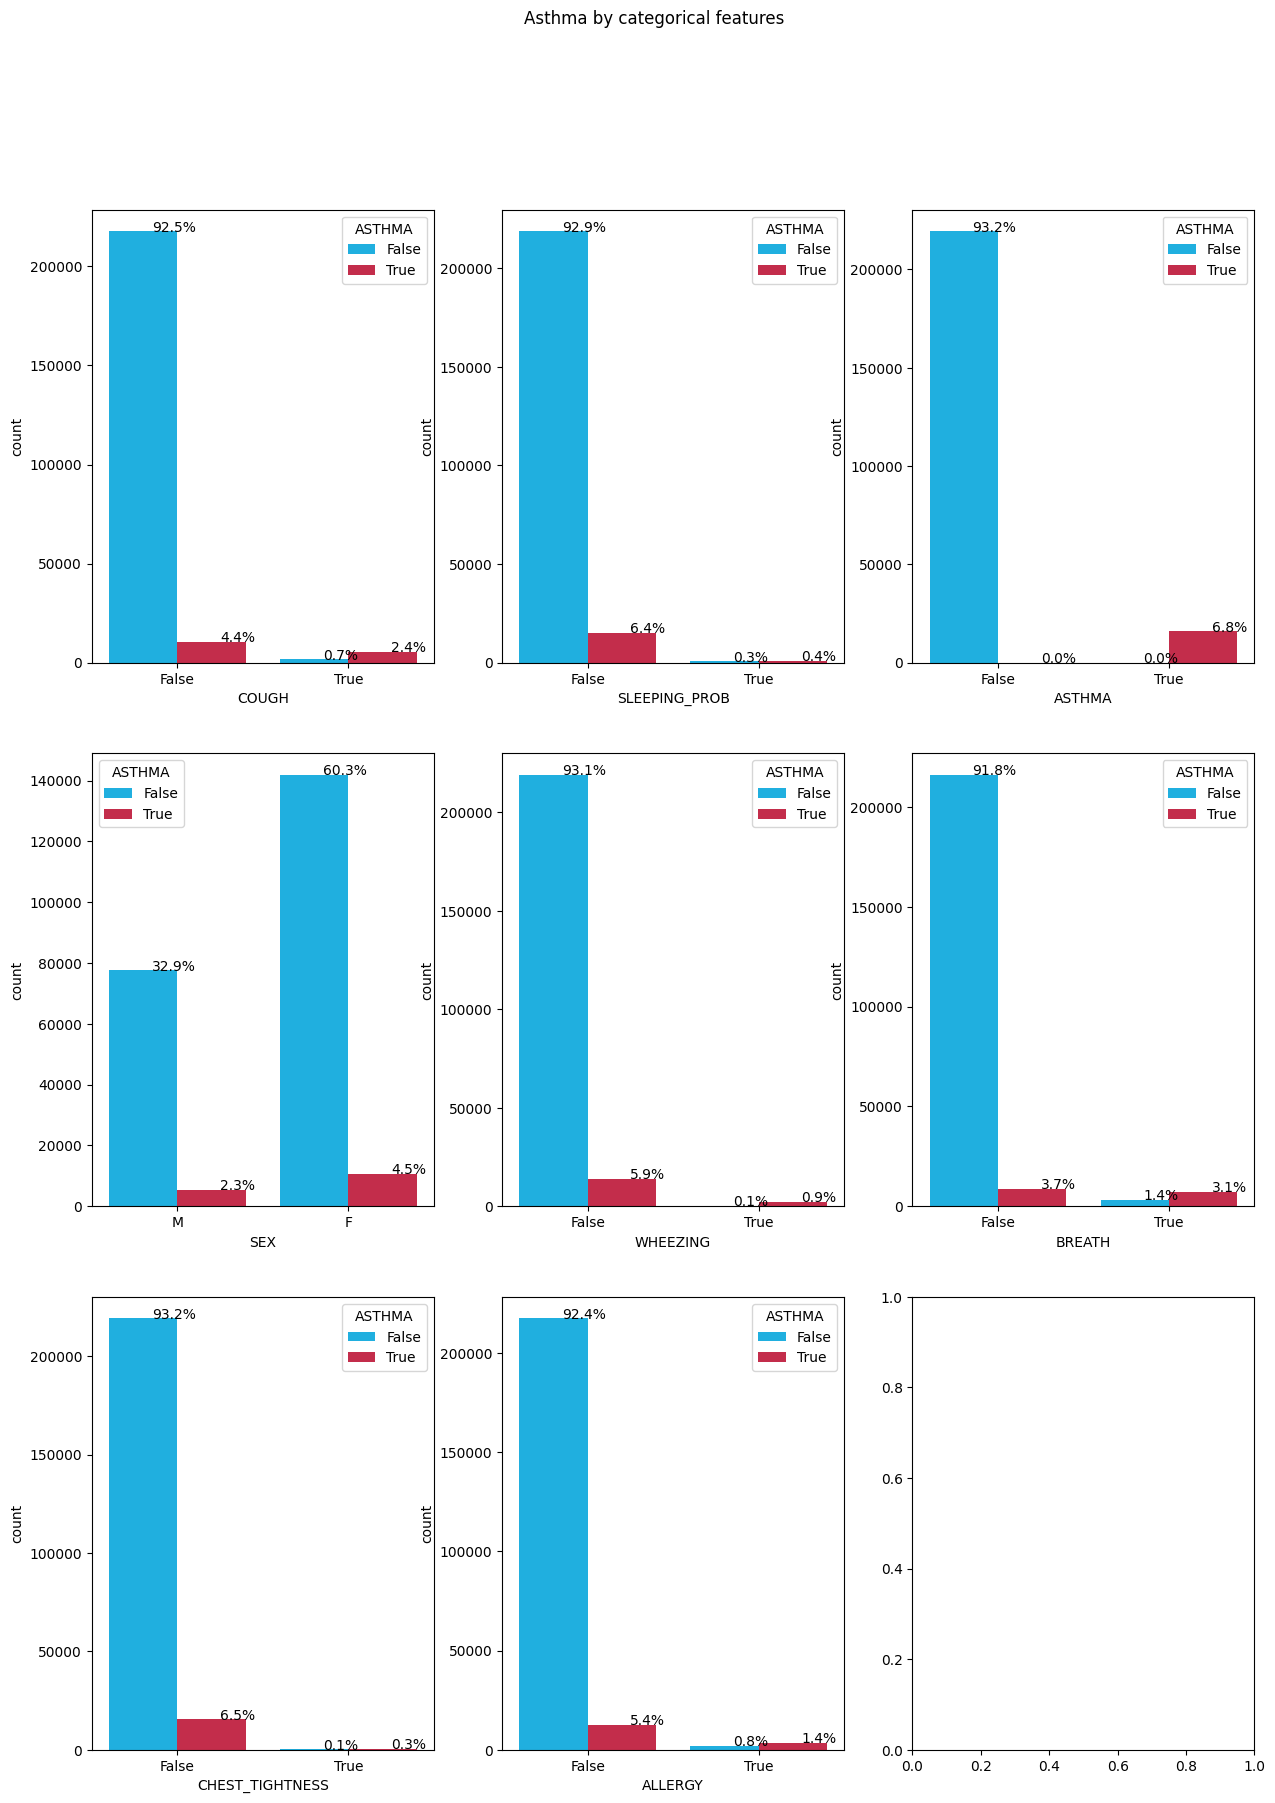

In [181]:
bivariate_bar_plot_for_a(3, categorical_a.copy(), (15,20))

In [182]:
def bivariate_bar_plot_for_d(n_cols, columns, figsize=(12,8)):
    n_rows = int(np.ceil(len(columns) / n_cols))
    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = figsize)
    plt.suptitle('Diabetes by categorical features')

    for i, col in enumerate(columns):
        x = sns.countplot(data=data_dict['D'][categorical_d], x=col, hue='Diabetes', palette = ['deepskyblue','crimson'], ax=ax[i//n_cols, i%n_cols])
        for z in x.patches:
          x.annotate('{:.1f}'.format((z.get_height()/data_dict['D'][categorical_d].shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [183]:
n_cols = 3
n_rows = n_rows = int(np.ceil(len(categorical_d.copy()) / n_cols))

"""Histogram using plotly"""
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=tuple(categorical_d.copy()))

for i, col in enumerate(categorical_d.copy()):
    counts = data_dict['D'][col].value_counts()
    fig.add_trace(go.Bar(name=col, x=counts.index, y=counts.values), 
                  row=i//n_cols + 1,
                  col=i%n_cols + 1)

fig.update_layout(title="Histogram plot of categorical columns",
                 height=800,
                 width=1000,
                 showlegend=False)

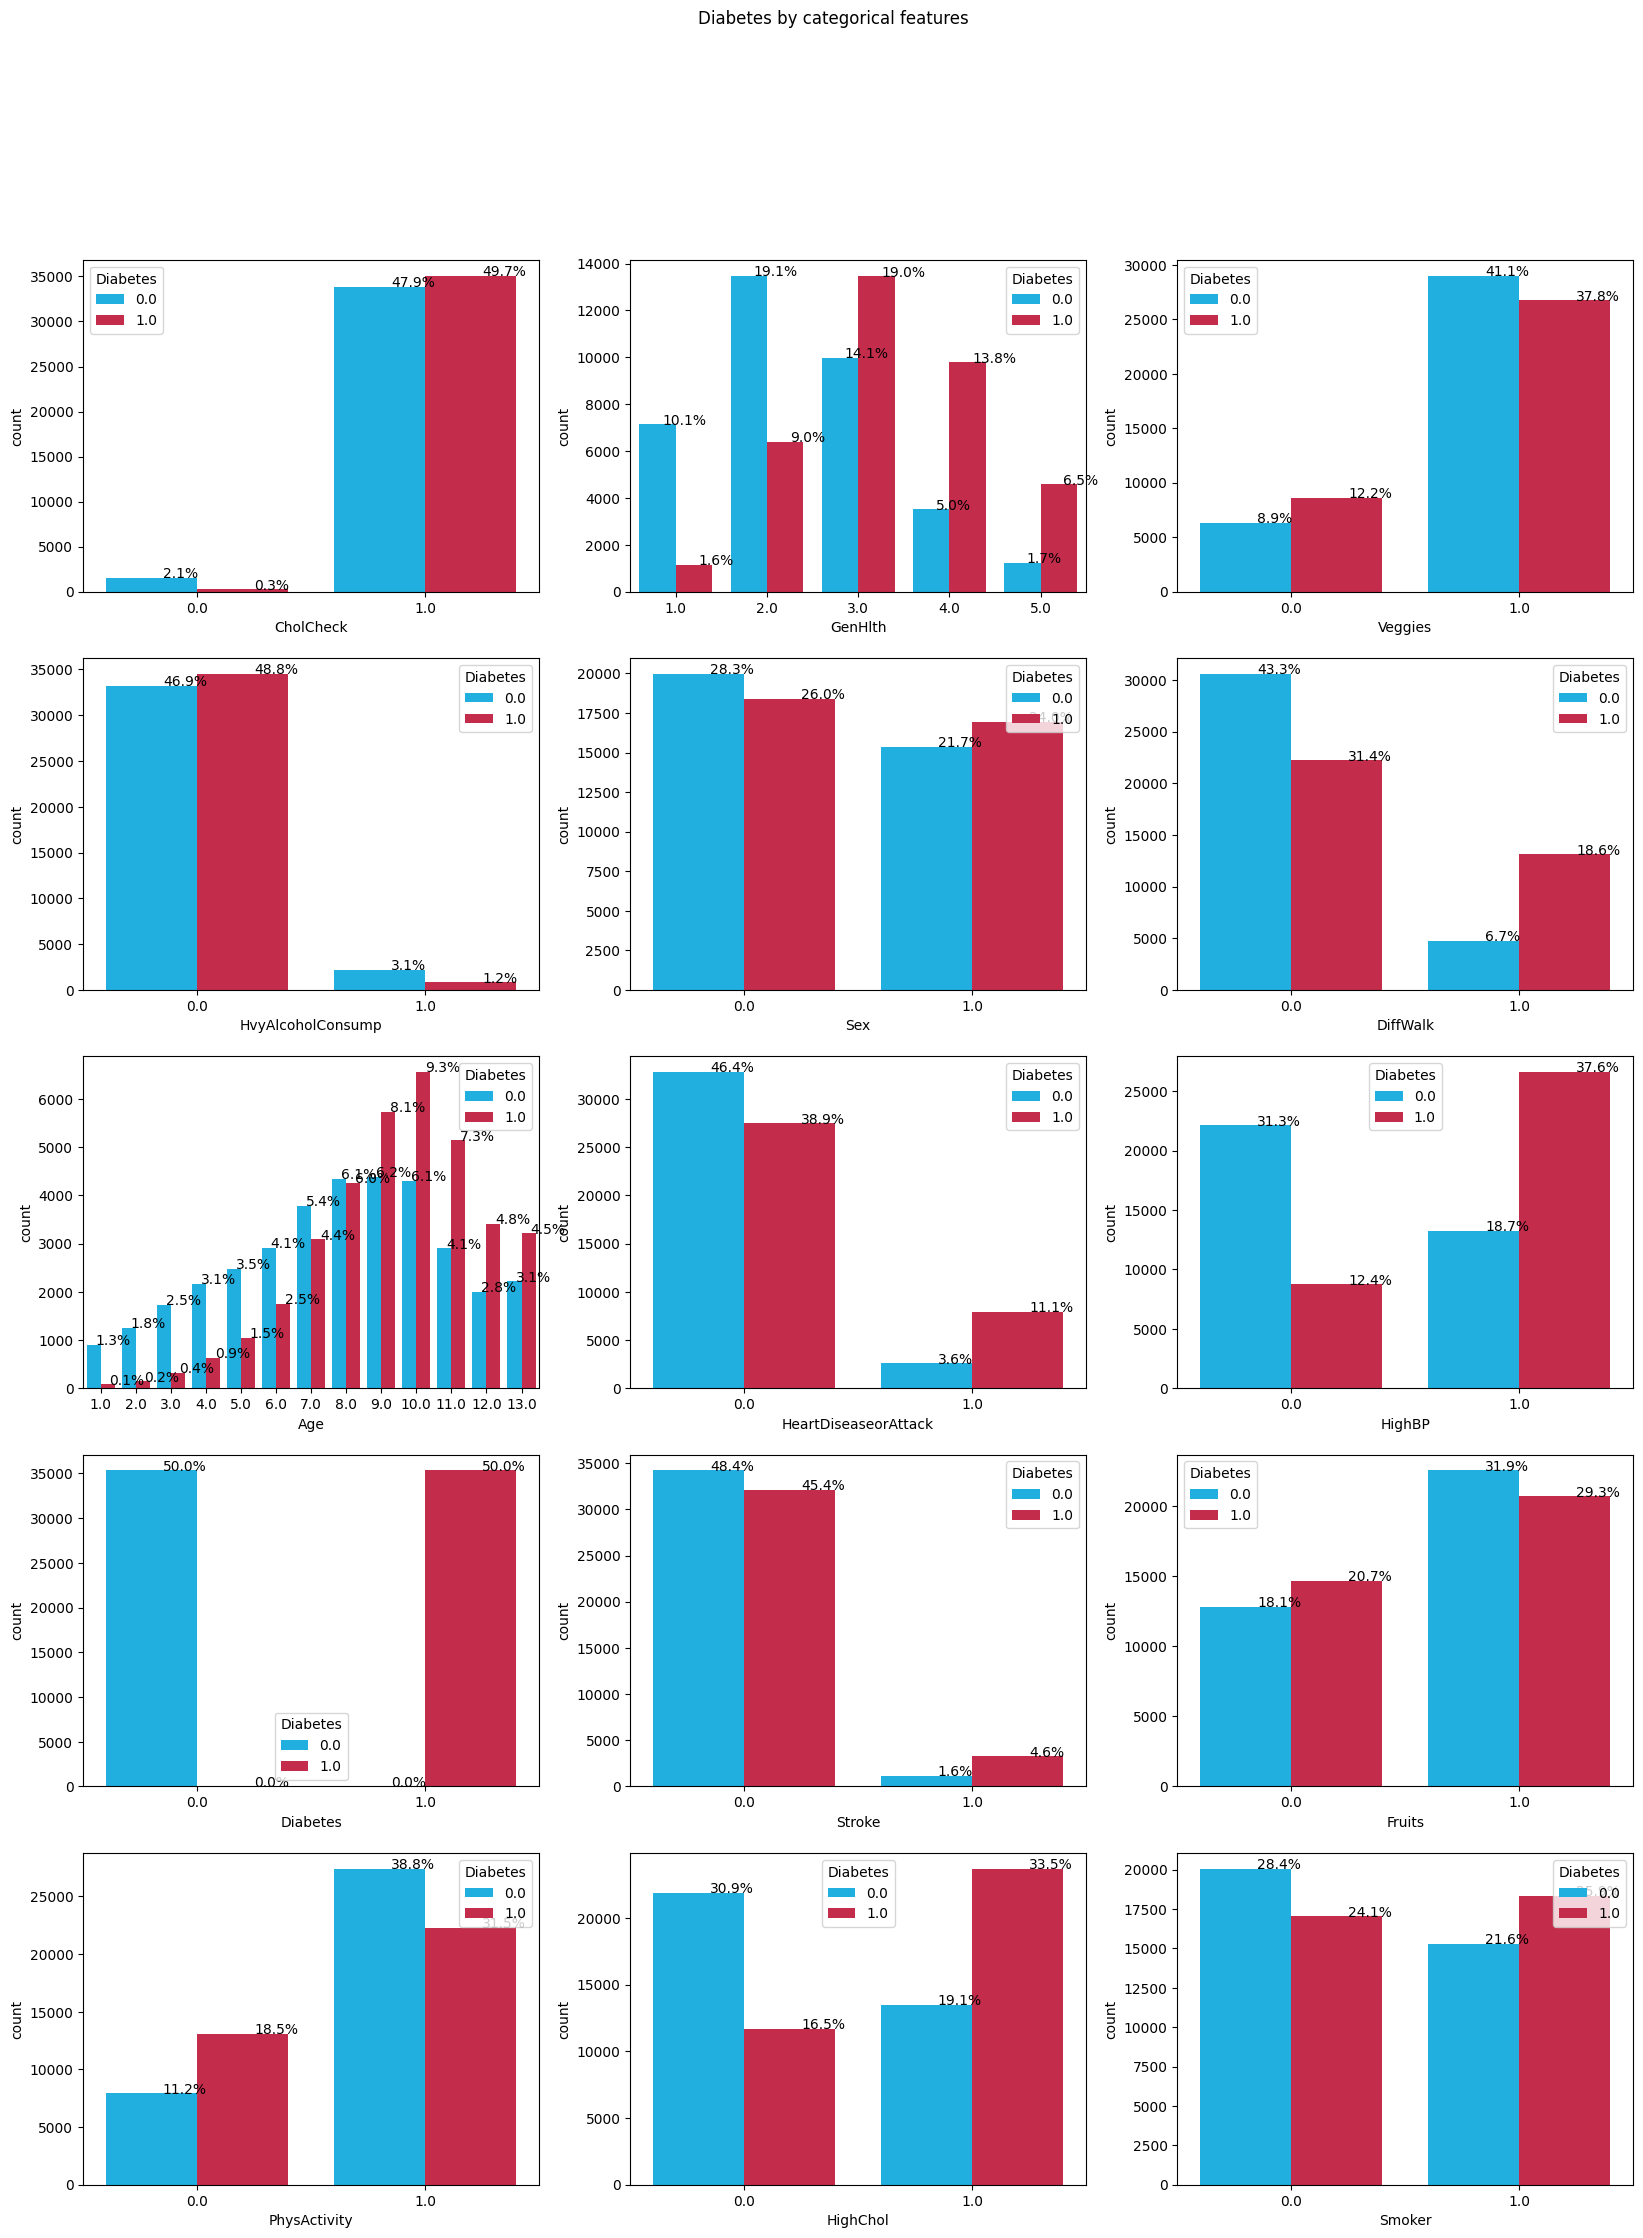

In [184]:
bivariate_bar_plot_for_d(3, categorical_d.copy(), (20,25))

In [185]:
def bivariate_bar_plot_for_s(n_cols, columns, figsize=(12,8)):
    n_rows = int(np.ceil(len(columns) / n_cols))
    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = figsize)
    plt.suptitle('Stroke by categorical features')

    for i, col in enumerate(columns):
        x = sns.countplot(data=data_dict['S'][categorical_s], x=col, hue='stroke', palette = ['deepskyblue','crimson'], ax=ax[i//n_cols, i%n_cols])
        for z in x.patches:
          x.annotate('{:.1f}'.format((z.get_height()/data_dict['S'][categorical_s].shape[0])*100)+'%',(z.get_x()+0.25, z.get_height()+0.01))

In [186]:
n_cols = 3
n_rows = n_rows = int(np.ceil(len(categorical_s.copy()) / n_cols))

"""Histogram using plotly"""
fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=tuple(categorical_s.copy()))

for i, col in enumerate(categorical_s.copy()):
    counts = data_dict['S'][col].value_counts()
    fig.add_trace(go.Bar(name=col, x=counts.index, y=counts.values), 
                  row=i//n_cols + 1,
                  col=i%n_cols + 1)

fig.update_layout(title="Histogram plot of categorical columns",
                 height=800,
                 width=1000,
                 showlegend=False)

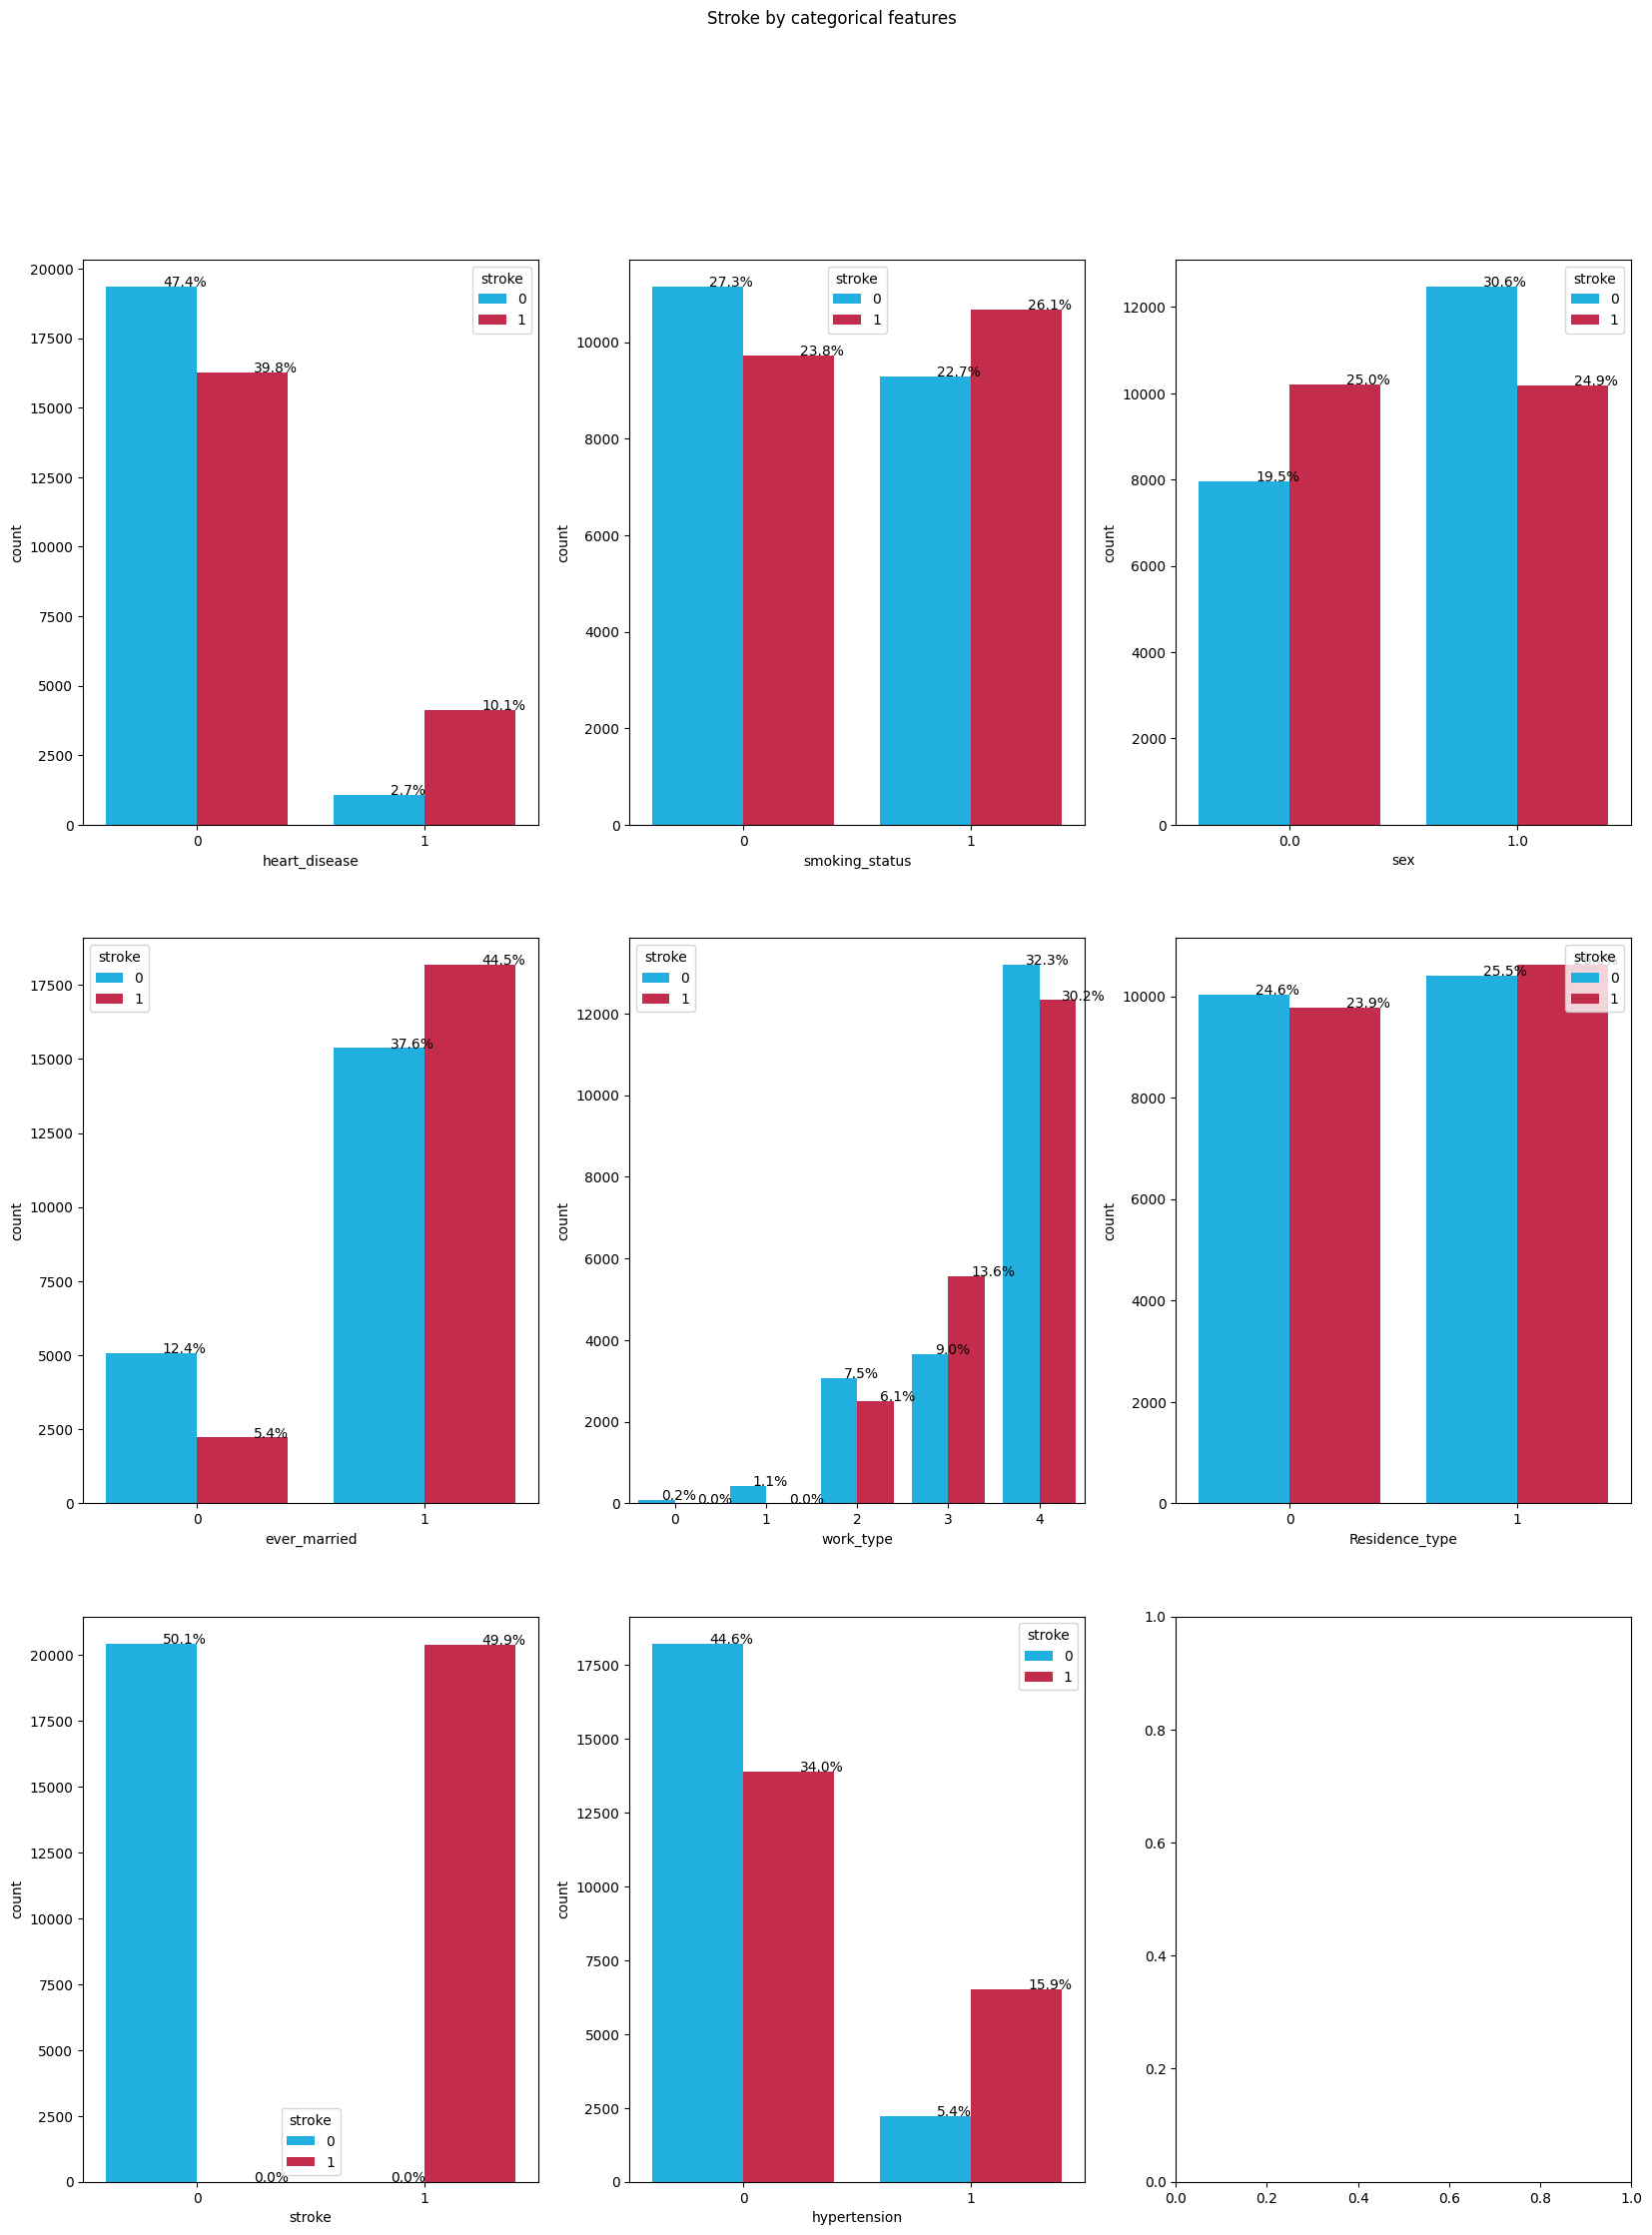

In [187]:
bivariate_bar_plot_for_s(3, categorical_s.copy(), (20,25))

# Data Preparation

## Convert the categorical variable to numerical
##### Only do for Asthma dataset as other dataset already converted to numerical

In [188]:
for col in data_dict['A'].select_dtypes(include=['object', 'bool']).columns:
    unique_value = np.unique(data_dict['A'][col])
    data_dict['A'][col] = data_dict['A'][col].replace(unique_value, np.arange(len(unique_value)))
    print(f"{col:<16}: {unique_value} have been converted to {np.arange(len(unique_value))}")

SEX             : ['F' 'M'] have been converted to [0 1]
SLEEPING_PROB   : [False  True] have been converted to [0 1]
CHEST_TIGHTNESS : [False  True] have been converted to [0 1]
BREATH          : [False  True] have been converted to [0 1]
COUGH           : [False  True] have been converted to [0 1]
ALLERGY         : [False  True] have been converted to [0 1]
WHEEZING        : [False  True] have been converted to [0 1]
ASTHMA          : [False  True] have been converted to [0 1]


In [189]:
#Check the data type again to make sure it has change to numerical
data_dict['A'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 235396 entries, 0 to 309225
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AGE_YRS          235396 non-null  float64
 1   SEX              235396 non-null  int32  
 2   SLEEPING_PROB    235396 non-null  int32  
 3   CHEST_TIGHTNESS  235396 non-null  int32  
 4   BREATH           235396 non-null  int32  
 5   COUGH            235396 non-null  int32  
 6   ALLERGY          235396 non-null  int32  
 7   WHEEZING         235396 non-null  int32  
 8   ASTHMA           235396 non-null  int32  
dtypes: float64(1), int32(8)
memory usage: 18.8 MB


# Correlation Matrix

<Axes: >

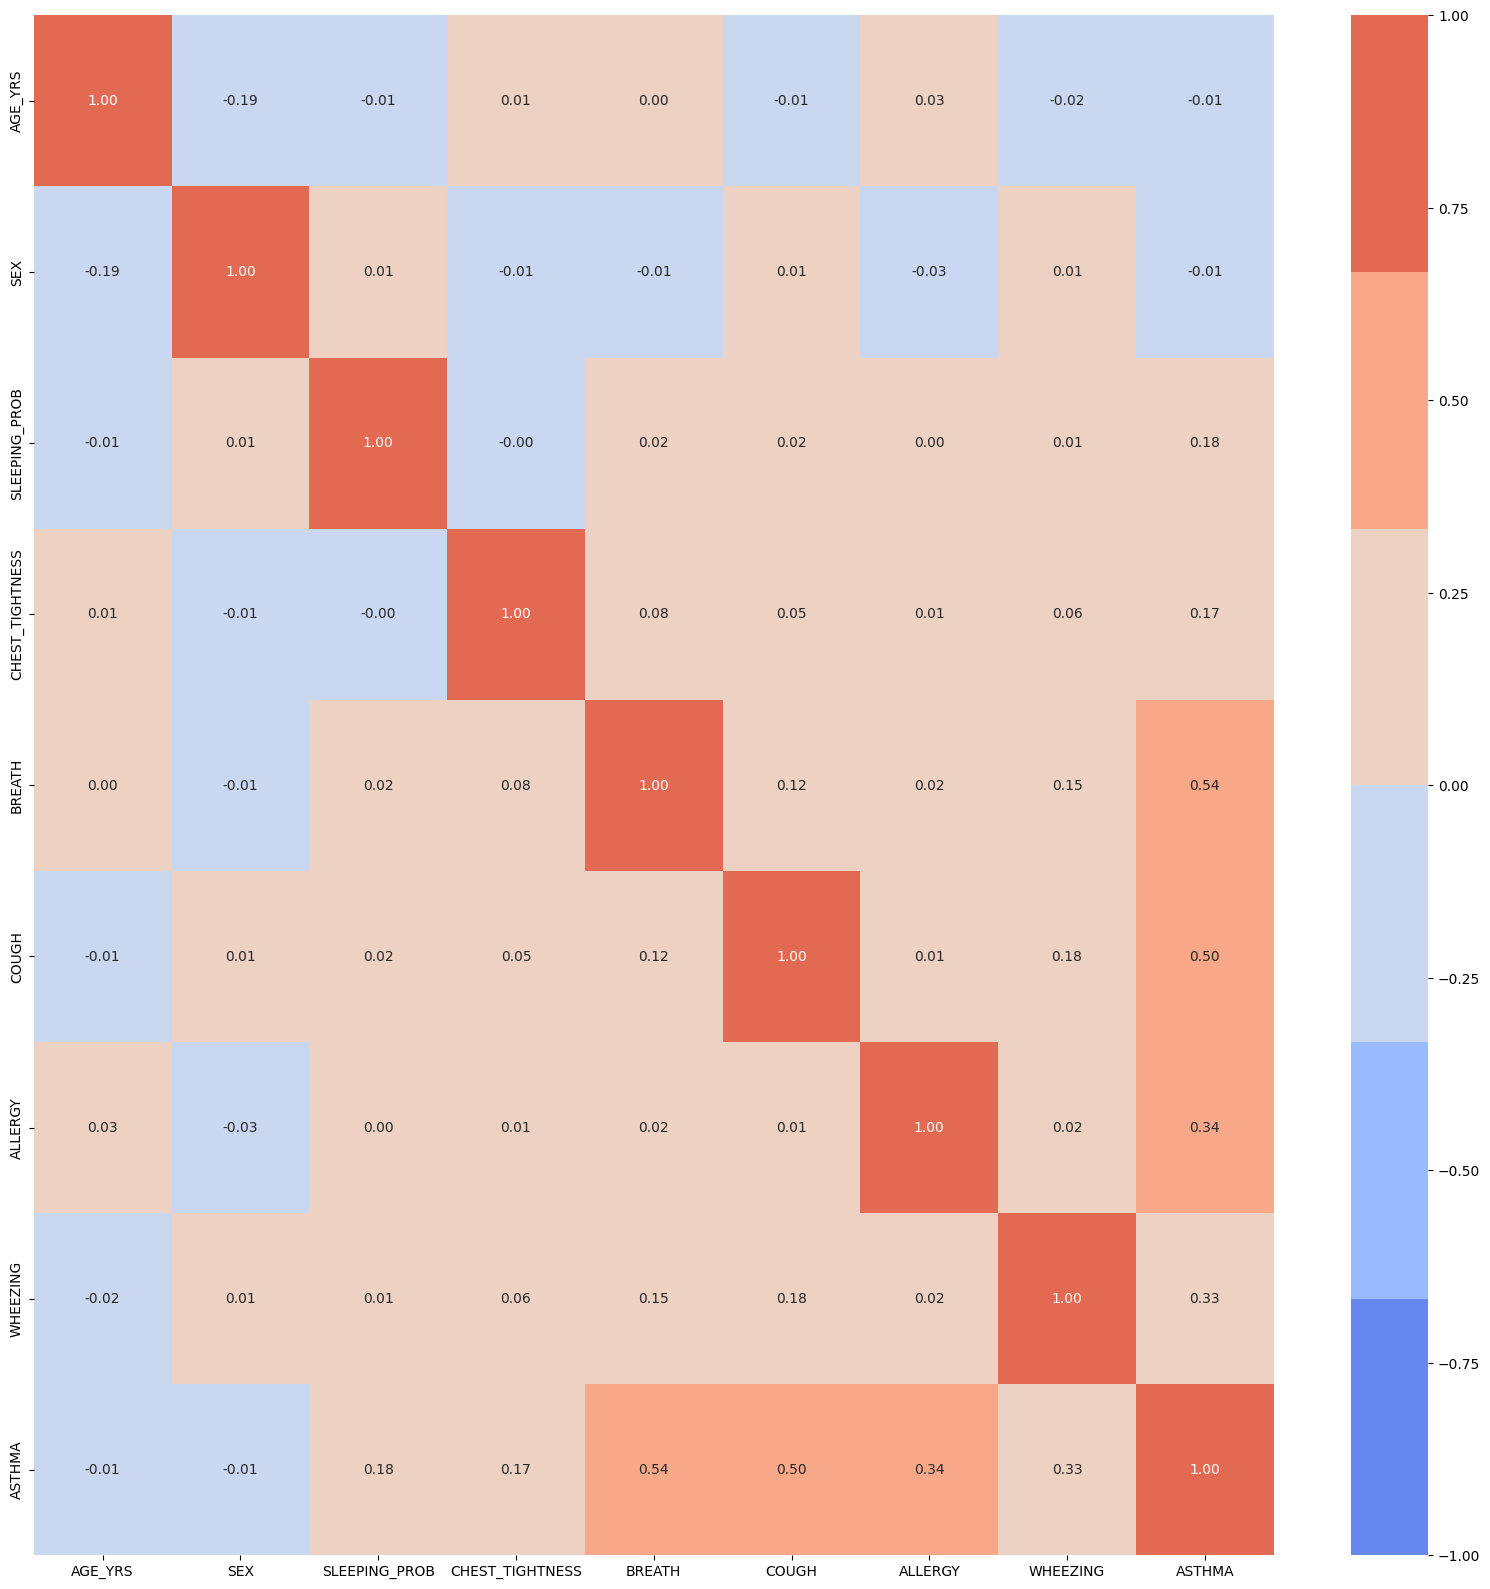

In [190]:
# Overall covariance matrix for Asthma
fig, ax = plt.subplots(figsize=(20, 20))   
sns.heatmap(data_dict['A'].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = sns.color_palette("coolwarm"), ax=ax)

<Axes: >

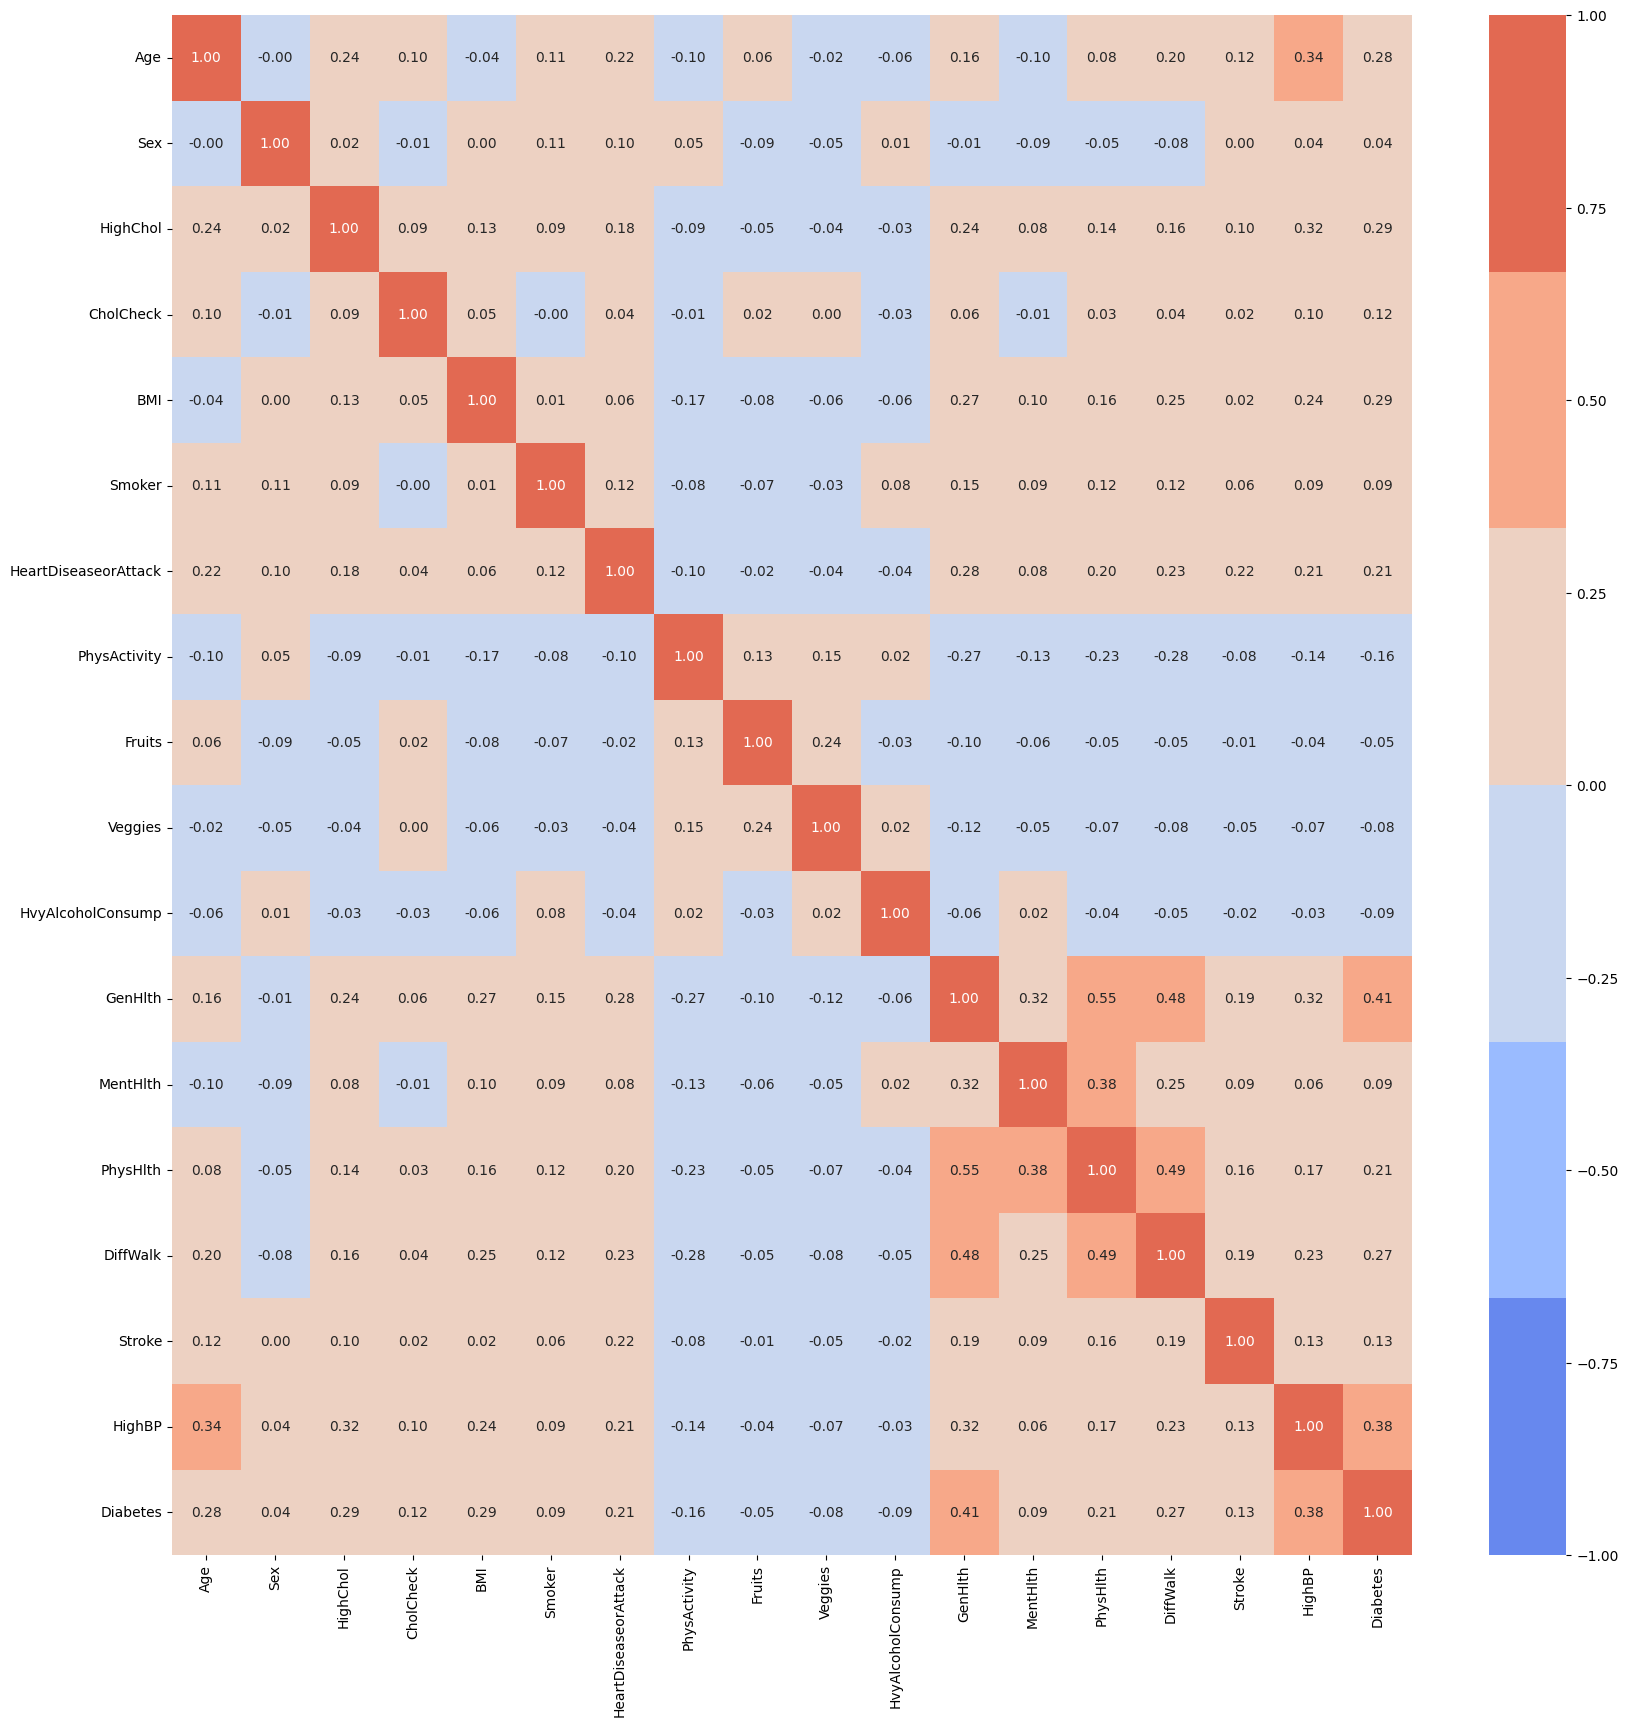

In [191]:
# Overall covariance matrix for Diabetes
fig, ax = plt.subplots(figsize=(20, 20))   
sns.heatmap(data_dict['D'].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = sns.color_palette("coolwarm"), ax=ax)

<Axes: >

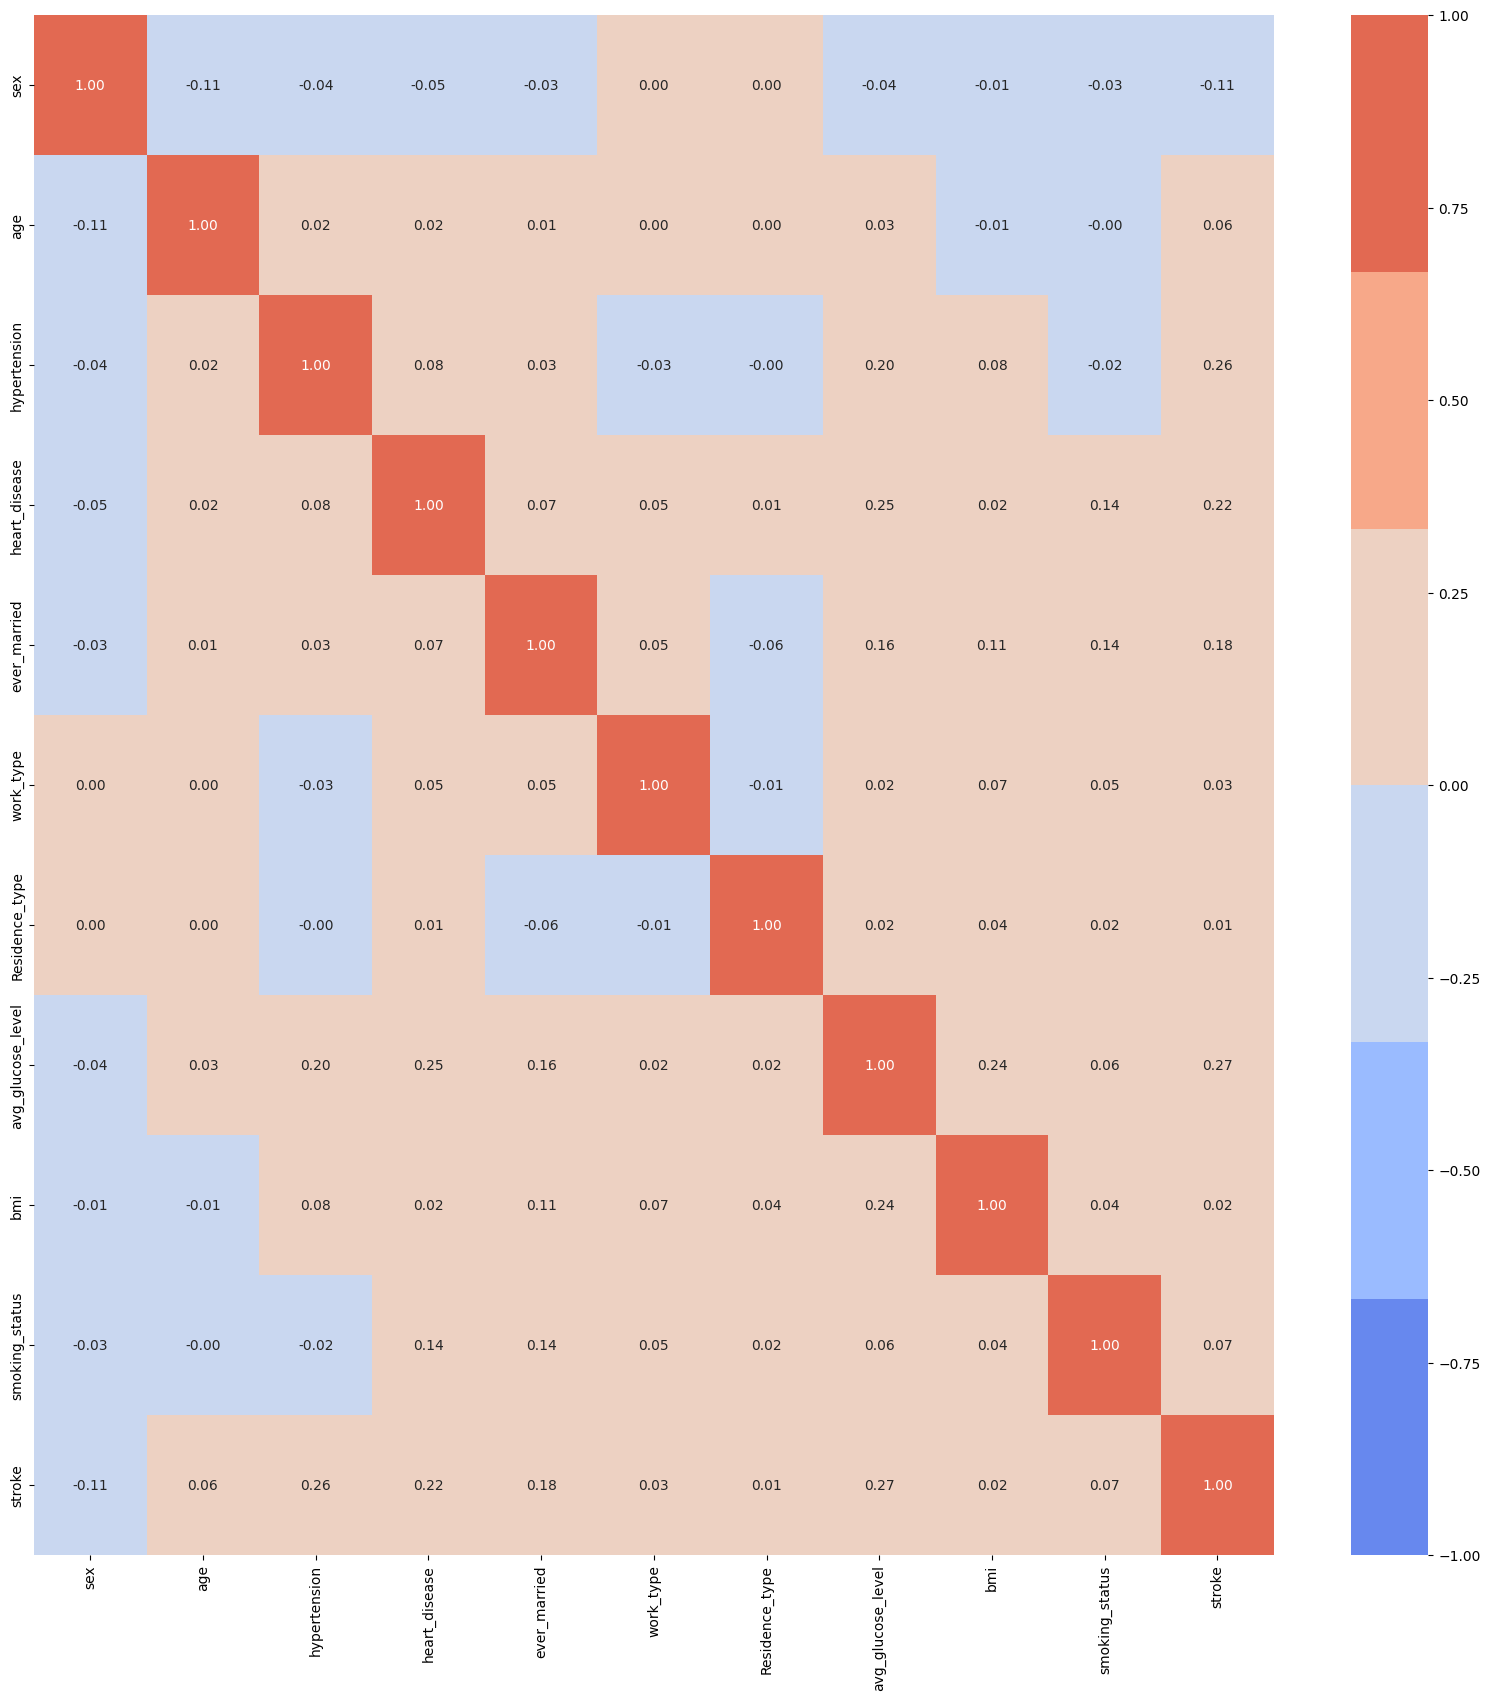

In [192]:
# Overall covariance matrix for Stroke
fig, ax = plt.subplots(figsize=(20, 20))   
sns.heatmap(data_dict['S'].corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f", cmap = sns.color_palette("coolwarm"), ax=ax)

In [193]:
# The correlation of each variable with the target variable (Asthma)
fig = go.Figure()
corr_target = data_dict['A'].corr()["ASTHMA"]
fig.add_trace(go.Bar(x=corr_target.index, y=corr_target.values))
fig.update_layout(title="Correlation Histogram between features and target", 
                  xaxis_title='Features', yaxis_title='Correlation', barmode='group')
fig.show()

In [194]:
# The correlation of each variable with the target variable (Diabetes)
fig = go.Figure()
corr_target = data_dict['D'].corr()["Diabetes"]
fig.add_trace(go.Bar(x=corr_target.index, y=corr_target.values))
fig.update_layout(title="Correlation Histogram between features and target", 
                  xaxis_title='Features', yaxis_title='Correlation', barmode='group')
fig.show()

In [195]:
# The correlation of each variable with the target variable (Stroke)
fig = go.Figure()
corr_target = data_dict['S'].corr()["stroke"]
fig.add_trace(go.Bar(x=corr_target.index, y=corr_target.values))
fig.update_layout(title="Correlation Histogram between features and target", 
                  xaxis_title='Features', yaxis_title='Correlation', barmode='group')
fig.show()

# Feature Selection

## Asthma

In [196]:
X_a = data_dict['A'].iloc[:, :-1]
y_a = data_dict['A'].iloc[:, -1]

[0.000874   0.0252386  0.03122539 0.04732336 0.07959039 0.16798493
 0.27555599 0.37220733]
Index(['SEX', 'CHEST_TIGHTNESS', 'AGE_YRS', 'SLEEPING_PROB', 'WHEEZING',
       'ALLERGY', 'COUGH', 'BREATH'],
      dtype='object')


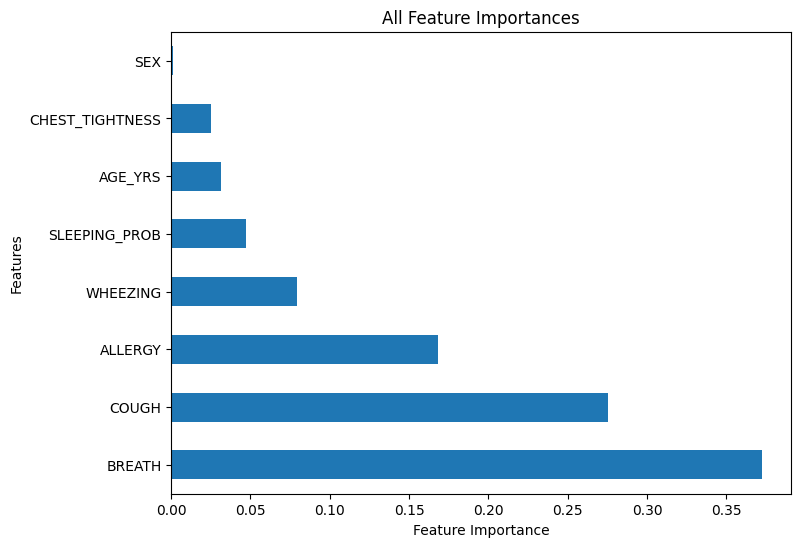

In [197]:
xgb_clf = xgb.XGBClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf.fit(X_a, y_a)
rf_clf.fit(X_a, y_a)
gb_clf.fit(X_a, y_a)

average_FI = (xgb_clf.feature_importances_ + rf_clf.feature_importances_  + gb_clf.feature_importances_ )/3
print(np.sort(average_FI))
print(X_a.columns[average_FI.argsort()])
plt.figure(figsize=(8,6))
feat_importances = pd.Series(average_FI, index=X_a.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('All Feature Importances')
plt.show()

In [198]:
# cols_drop = X_a.columns[average_FI.argsort()][:1].tolist() # Remove the last 1 least important features ## Remove only Sex(Gender)
# print(cols_drop)
# X_a = X_a.drop(columns=cols_drop)
# X_a.head()

In [199]:
numerical_cols_a = [col for col in X_a.columns if len(X_a[col].unique()) > 10]
categorical_cols_a = list(set(X_a.columns) - set(numerical_cols_a))
print(numerical_cols_a)
print(categorical_cols_a)

['AGE_YRS']
['COUGH', 'SLEEPING_PROB', 'SEX', 'WHEEZING', 'BREATH', 'CHEST_TIGHTNESS', 'ALLERGY']


In [200]:
# Calculating the skewness of the numerical columns to show evidence of the assumption made
df_skew = pd.DataFrame(X_a[numerical_cols_a].skew())
df_skew.columns = ['skewness']

# |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75
df_skew

,skewness,too_skewed
AGE_YRS,0.233546,False


## Diabetes

In [201]:
X_d = data_dict['D'].iloc[:, :-1]
y_d = data_dict['D'].iloc[:, -1]

[0.00905225 0.01208141 0.01233165 0.01373355 0.01400689 0.01771201
 0.01841141 0.01885157 0.0194938  0.023757   0.02617297 0.03329612
 0.05511566 0.09564424 0.11938874 0.18154244 0.32940829]
Index(['Stroke', 'PhysActivity', 'Veggies', 'Smoker', 'Fruits', 'Sex',
       'CholCheck', 'HvyAlcoholConsump', 'HeartDiseaseorAttack', 'DiffWalk',
       'MentHlth', 'PhysHlth', 'HighChol', 'Age', 'BMI', 'GenHlth', 'HighBP'],
      dtype='object')


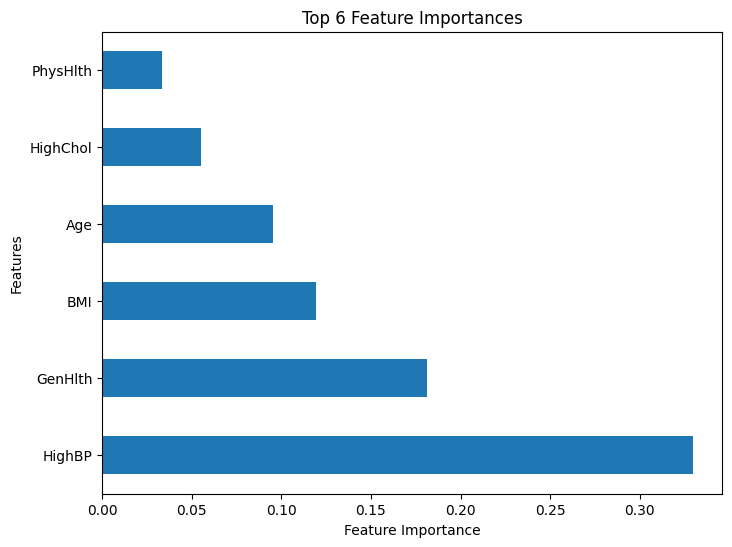

In [202]:
xgb_clf = xgb.XGBClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf.fit(X_d, y_d)
rf_clf.fit(X_d, y_d)
gb_clf.fit(X_d, y_d)

average_FI = (xgb_clf.feature_importances_ + rf_clf.feature_importances_  + gb_clf.feature_importances_ )/3
print(np.sort(average_FI))
print(X_d.columns[average_FI.argsort()])
plt.figure(figsize=(8,6))
feat_importances = pd.Series(average_FI, index=X_d.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 6 Feature Importances')
plt.show()

In [203]:
cols_drop = X_d.columns[average_FI.argsort()][:11].tolist()
# cols_drop.remove('PhysActivity')
print(cols_drop)
X_d = X_d.drop(columns=cols_drop)
X_d.head()

['Stroke', 'PhysActivity', 'Veggies', 'Smoker', 'Fruits', 'Sex', 'CholCheck', 'HvyAlcoholConsump', 'HeartDiseaseorAttack', 'DiffWalk', 'MentHlth']


,Age,HighChol,BMI,GenHlth,PhysHlth,HighBP
0,4.0,0.0,26.0,3.0,30.0,1.0
1,12.0,1.0,26.0,3.0,0.0,1.0
2,13.0,0.0,26.0,1.0,10.0,0.0
3,11.0,1.0,28.0,3.0,3.0,1.0
4,8.0,0.0,29.0,2.0,0.0,0.0


In [204]:
numerical_cols_d = [col for col in X_d.columns if len(X_d[col].unique()) > 10]
categorical_cols_d = list(set(X_d.columns) - set(numerical_cols_d))
print(numerical_cols_d)
print(categorical_cols_d)

['Age', 'BMI', 'PhysHlth']
['HighBP', 'GenHlth', 'HighChol']


In [205]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(X_d[numerical_cols_d].skew())
df_skew.columns = ['skewness']

# |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75
df_skew

,skewness,too_skewed
Age,-0.545923,False
BMI,1.719180,True
PhysHlth,1.657304,True


## Stroke

In [206]:
X_s = data_dict['S'].iloc[:, :-1]
y_s = data_dict['S'].iloc[:, -1]

[0.03857604 0.03902467 0.04325427 0.05428746 0.07120551 0.07348601
 0.08143402 0.09907204 0.1873766  0.31228337]
Index(['Residence_type', 'smoking_status', 'sex', 'work_type', 'age',
       'heart_disease', 'ever_married', 'hypertension', 'bmi',
       'avg_glucose_level'],
      dtype='object')


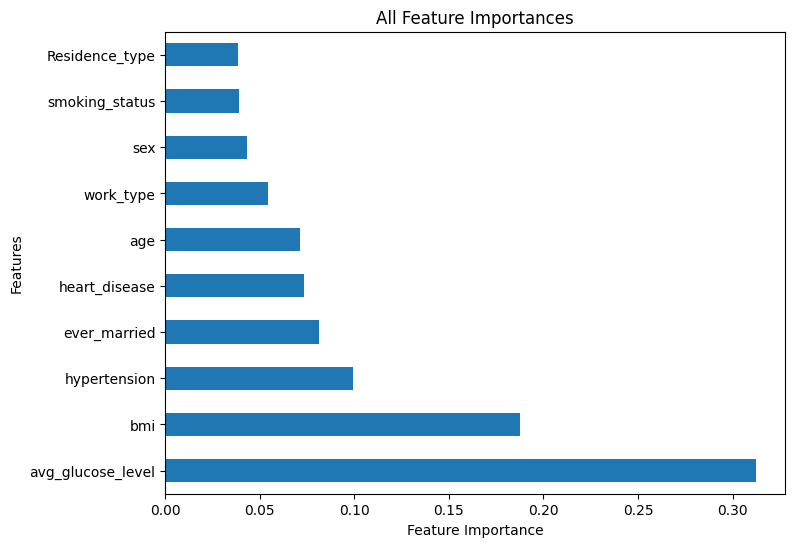

In [207]:
xgb_clf = xgb.XGBClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf.fit(X_s, y_s)
rf_clf.fit(X_s, y_s)
gb_clf.fit(X_s, y_s)

average_FI = (xgb_clf.feature_importances_ + rf_clf.feature_importances_  + gb_clf.feature_importances_ )/3
print(np.sort(average_FI))
print(X_s.columns[average_FI.argsort()])
plt.figure(figsize=(8,6))
feat_importances = pd.Series(average_FI, index=X_s.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('All Feature Importances')
plt.show()

In [208]:
cols_drop = X_s.columns[average_FI.argsort()][:1].tolist()
# cols_drop.remove('PhysActivity')
print(cols_drop)
X_s = X_s.drop(columns=cols_drop)
X_s.head()

['Residence_type']


,sex,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.0,63.0,0,1,1,4,228.69,36.6,1
1,1.0,42.0,0,1,1,4,105.92,32.5,0
2,0.0,61.0,0,0,1,4,171.23,34.4,1
3,1.0,41.0,1,0,1,3,174.12,24.0,0
4,1.0,85.0,0,0,1,4,186.21,29.0,1


In [209]:
X_s

,sex,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.0,63.0,0,1,1,4,228.69,36.6,1
1,1.0,42.0,0,1,1,4,105.92,32.5,0
2,0.0,61.0,0,0,1,4,171.23,34.4,1
3,1.0,41.0,1,0,1,3,174.12,24.0,0
4,1.0,85.0,0,0,1,4,186.21,29.0,1
...,...,...,...,...,...,...,...,...,...
40905,1.0,38.0,0,0,0,4,120.94,29.7,1
40906,0.0,53.0,0,0,1,4,77.66,40.8,0
40907,1.0,32.0,0,0,1,2,231.95,33.2,0
40908,1.0,42.0,0,0,1,3,216.38,34.5,0


In [210]:
numerical_cols_s = [col for col in X_s.columns if len(X_s[col].unique()) > 10]
categorical_cols_s = list(set(X_s.columns) - set(numerical_cols_s))
print(numerical_cols_s)
print(categorical_cols_s)

['age', 'avg_glucose_level', 'bmi']
['heart_disease', 'smoking_status', 'sex', 'ever_married', 'work_type', 'hypertension']


In [211]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(X_s[numerical_cols_s].skew())
df_skew.columns = ['skewness']

# |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75
df_skew

,skewness,too_skewed
age,-0.067865,False
avg_glucose_level,0.945126,True
bmi,1.077175,True


# Data Normalization

In [212]:
X_a.shape

(235396, 8)

In [213]:
# Normalize for Asthma Dataset
sc = MinMaxScaler()
sc = sc.fit(X_a)
columns_name = X_a.columns
X_a = sc.transform(X_a)
X_a = pd.DataFrame(X_a, columns = columns_name)
X_a

# Save the scaler model to a pickle file
with open('scAsthma.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [214]:
X_d.shape

(70692, 6)

In [215]:
# Normalize for Diabetes Dataset
sc = MinMaxScaler()
sc = sc.fit(X_d)
columns_name = X_d.columns
X_d = sc.transform(X_d)
print(X_d.shape)
print(len(columns_name))
X_d = pd.DataFrame(X_d, columns = columns_name)
X_d

# # Save the scaler model to a pickle file
# with open('scDiabetes.pkl', 'wb') as file:
#     pickle.dump(sc, file)

(70692, 6)
6


,Age,HighChol,BMI,GenHlth,PhysHlth,HighBP
0,0.250000,0.0,0.162791,0.50,1.000000,1.0
1,0.916667,1.0,0.162791,0.50,0.000000,1.0
2,1.000000,0.0,0.162791,0.00,0.333333,0.0
3,0.833333,1.0,0.186047,0.50,0.100000,1.0
4,0.583333,0.0,0.197674,0.25,0.000000,0.0
...,...,...,...,...,...,...
70687,0.416667,1.0,0.290698,0.75,0.000000,0.0
70688,0.750000,1.0,0.197674,0.25,0.000000,0.0
70689,1.000000,1.0,0.151163,1.00,0.000000,1.0
70690,0.833333,1.0,0.069767,0.75,0.000000,1.0


In [216]:
X_s.shape

(40849, 9)

In [217]:
# Normalize for Stroke Dataset
sc = MinMaxScaler()
sc = sc.fit(X_s)
columns_name = X_s.columns
X_s = sc.transform(X_s)
print(len(columns_name))
X_s = pd.DataFrame(X_s, columns = columns_name)
X_s

# # Save the scaler model to a pickle file
# with open('scStroke.pkl', 'wb') as file:
#     pickle.dump(sc, file)

9


,sex,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.0,0.611650,0.0,1.0,1.0,1.00,0.801265,0.311801,1.0
1,1.0,0.407767,0.0,1.0,1.0,1.00,0.234512,0.260870,0.0
2,0.0,0.592233,0.0,0.0,1.0,1.00,0.536008,0.284472,1.0
3,1.0,0.398058,1.0,0.0,1.0,0.75,0.549349,0.155280,0.0
4,1.0,0.825243,0.0,0.0,1.0,1.00,0.605161,0.217391,1.0
...,...,...,...,...,...,...,...,...,...
40844,1.0,0.368932,0.0,0.0,0.0,1.00,0.303850,0.226087,1.0
40845,0.0,0.514563,0.0,0.0,1.0,1.00,0.104053,0.363975,0.0
40846,1.0,0.310680,0.0,0.0,1.0,0.50,0.816314,0.269565,0.0
40847,1.0,0.407767,0.0,0.0,1.0,0.75,0.744437,0.285714,0.0


# Data Transformation

## Quantile Transformation to remove extreme outliers

In [218]:
X_qt_d = X_d.copy()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
# numerical_cols.remove('Age')

scalers = []

qt_bmi = qt.fit(X_d[['BMI']])
X_d[['BMI']] = qt.transform(X_d[['BMI']])
scalers.append(qt_bmi)
qt_bmi = qt.fit(X_d[['PhysHlth']])
X_d[['PhysHlth']] = qt.transform(X_d[['PhysHlth']])
scalers.append(qt_bmi)

# # Save the scaler model to a pickle file
# with open('qtDiabetes.pkl', 'wb') as file:
#     pickle.dump(scalers, file)


In [219]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(X_d[numerical_cols_d].skew())
df_skew.columns = ['skewness']

# |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75
df_skew

,skewness,too_skewed
Age,-0.545923,False
BMI,0.002485,False
PhysHlth,0.692441,False


In [220]:
X_qt_s = X_s.copy()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
# numerical_cols.remove('Age')

scalers = []

qt_avg = qt.fit(X_s[['avg_glucose_level']])
X_s[['avg_glucose_level']] = qt.transform(X_s[['avg_glucose_level']])
scalers.append(qt_avg)
qt_bmi = qt.fit(X_s[['bmi']])
X_s[['bmi']] = qt.transform(X_s[['bmi']])
scalers.append(qt_bmi)

# # Save the scaler model to a pickle file
# with open('qtStroke.pkl', 'wb') as file:
#     pickle.dump(scalers, file)


In [221]:
X_s.head()

,sex,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.0,0.611650,0.0,1.0,1.0,1.00,1.489816,0.964751,1.0
1,1.0,0.407767,0.0,1.0,1.0,1.00,0.186945,0.494090,0.0
2,0.0,0.592233,0.0,0.0,1.0,1.00,0.685567,0.711210,1.0
3,1.0,0.398058,1.0,0.0,1.0,0.75,0.695130,-1.009729,0.0
4,1.0,0.825243,0.0,0.0,1.0,1.00,0.787718,-0.067867,1.0


In [222]:
"""Calculating the skewness of the numerical columns to show evidence of the assumption we made"""
df_skew = pd.DataFrame(X_s[numerical_cols_s].skew())
df_skew.columns = ['skewness']

# |skew| > 0.75 is considered as moderately skewed, |skew| > 1.0 is considered as highly skewed
df_skew["too_skewed"] = abs(df_skew["skewness"]) > 0.75
df_skew

,skewness,too_skewed
age,-0.067865,False
avg_glucose_level,0.286923,False
bmi,-0.004713,False


# Data spliting for training and testing

In [223]:
# Asthma Data Split
y_a = y_a.astype('int')
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.3, random_state=42)
print(f"After spliting Asthma X_train shape: {X_train_a.shape} Asthma y_train shape: {y_train_a.shape}")
print(f"After spliting Asthma X_test  shape: {X_test_a.shape} Asthma y_test  shape: {y_test_a.shape}")

After spliting Asthma X_train shape: (164777, 8) Asthma y_train shape: (164777,)
After spliting Asthma X_test  shape: (70619, 8) Asthma y_test  shape: (70619,)


In [224]:
# Diabetes Data Split
y_d = y_d.astype('int')
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.3, random_state=42)
print(f"After spliting Diabetes X_train shape: {X_train_d.shape} Diabetes y_train shape: {y_train_d.shape}")
print(f"After spliting Diabetes X_test  shape: {X_test_d.shape} Diabetes y_test  shape: {y_test_d.shape}")

After spliting Diabetes X_train shape: (49484, 6) Diabetes y_train shape: (49484,)
After spliting Diabetes X_test  shape: (21208, 6) Diabetes y_test  shape: (21208,)


In [225]:
# Stroke Data Split
y_s = y_s.astype('int')
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.3, random_state=42)
print(f"After spliting Stroke X_train shape: {X_train_s.shape} Stroke y_train shape: {y_train_s.shape}")
print(f"After spliting Stroke X_test  shape: {X_test_s.shape} Stroke y_test  shape: {y_test_s.shape}")

After spliting Stroke X_train shape: (28594, 9) Stroke y_train shape: (28594,)
After spliting Stroke X_test  shape: (12255, 9) Stroke y_test  shape: (12255,)


In [226]:
X_test_s

,sex,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
25165,0.0,0.533981,0.0,0.0,0.0,1.00,-0.328600,0.964751,1.0
18654,0.0,0.941748,1.0,0.0,1.0,0.75,-0.937119,-0.822449,0.0
18938,0.0,0.660194,0.0,1.0,1.0,1.00,-1.910163,0.465906,1.0
14148,0.0,0.407767,0.0,1.0,1.0,1.00,-1.910163,0.465906,1.0
8615,0.0,0.106796,0.0,0.0,1.0,1.00,-0.811927,0.075421,1.0
...,...,...,...,...,...,...,...,...,...
10458,0.0,0.679612,0.0,0.0,0.0,0.75,-0.256461,-0.494090,0.0
9109,1.0,0.077670,0.0,0.0,1.0,1.00,0.166536,0.243504,0.0
13424,0.0,0.320388,0.0,0.0,1.0,0.50,-1.545421,1.467336,0.0
9870,1.0,0.106796,0.0,0.0,1.0,1.00,0.563424,0.383428,1.0


In [227]:
X_train_d.shape

(49484, 6)

# Model Building

## Asthma Prediction Model

### XGBoost Model

In [228]:
def xgb_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a):
    # Initialize the XGBoost classifier
    XGB = xgb.XGBClassifier()

    # Train the model
    XGB.fit(X_train_a, y_train_a)

    # Predict on the test set
    predicted_y = XGB.predict(X_test_a)

    # Evaluate the model
    report = classification_report(y_test_a, predicted_y)
    matrix = confusion_matrix(y_test_a, predicted_y)

    return XGB, report, matrix


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     65794
           1       0.71      0.90      0.79      4825

    accuracy                           0.97     70619
   macro avg       0.85      0.94      0.89     70619
weighted avg       0.97      0.97      0.97     70619



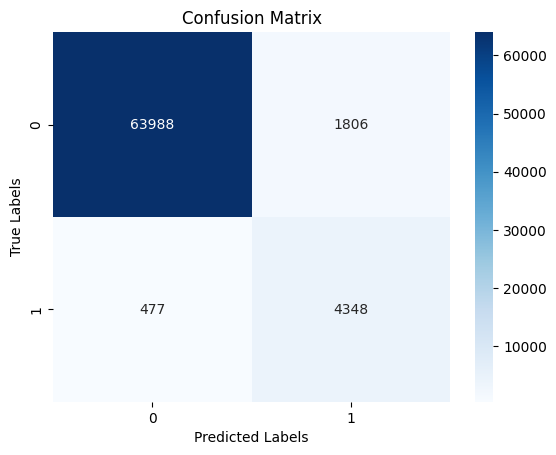

In [229]:
xgbAsthmaModel, report, matrix = xgb_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a)

# Print classification report
print("Classification Report:")
print(report)


# Print  and confusion matrix
y_pred_test = xgbAsthmaModel.predict(X_test_a)

# Assuming y_pred_test contains the predicted labels and y_test_a contains the true labels
cm = confusion_matrix(y_test_a, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()


In [230]:
# xgbAsthmaModel, report, matrix = xgb_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a)
# # Save the trained model with pickle
# with open('xgbAsthmaModel.pkl', 'wb') as file:
#     pickle.dump(xgbAsthmaModel, file)


### Random Forest Model

In [231]:
def rf_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a):
    # Initialize the random forest classifier
    RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

    # Define the parameter range for grid search
    param_grid = {'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]}

    # Perform grid search
    gridRF = GridSearchCV(RF, param_grid)
    gridRF.fit(X_train_a, y_train_a)



    # Predict on train and test sets
    y_pred_train = gridRF.predict(X_train_a)
    y_pred_test = gridRF.predict(X_test_a)

    # Calculate and print accuracy scores
    train_accuracy = accuracy_score(y_train_a, y_pred_train)
    test_accuracy = accuracy_score(y_test_a, y_pred_test)

    return gridRF, train_accuracy, test_accuracy


In [232]:
rfAsthmaModel, train_acc, test_acc = rf_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a)

# Print best parameters
print("Best Parameters:", rfAsthmaModel.best_params_)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

# Print classification report and confusion matrix
y_pred_test = rfAsthmaModel.predict(X_test_a)
print("Classification Report:")
print(classification_report(y_test_a, y_pred_test))

# Assuming y_pred_test contains the predicted labels and y_test_a contains the true labels
cm = confusion_matrix(y_test_a, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()


c:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

c:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too 

KeyboardInterrupt: 

### Logistic Regression Model

In [ ]:
def lr_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a):
    # Initialize the logistic regression classifier
    LR = LogisticRegression(solver='liblinear', random_state=0)

    # Train the model
    LR.fit(X_train_a, y_train_a)

    # Predict on the test set
    predicted_y = LR.predict(X_test_a)

    # Evaluate the model
    report = classification_report(y_test_a, predicted_y)
    matrix = confusion_matrix(y_test_a, predicted_y)

    return LR, report, matrix

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     65794
           1       0.68      0.97      0.80      4825

    accuracy                           0.97     70619
   macro avg       0.84      0.97      0.89     70619
weighted avg       0.98      0.97      0.97     70619



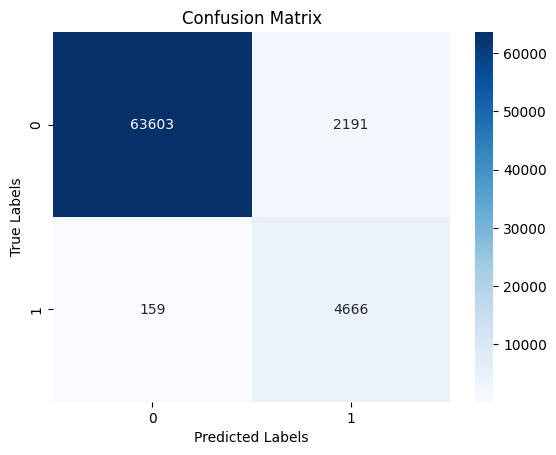

In [ ]:
lrAsthmaModel, report, matrix = lr_asthma_model(X_train_a, y_train_a, X_test_a, y_test_a)

# Print the classification report
print("Classification Report:")
print(report)

# Print classification report and confusion matrix
y_pred_test = lrAsthmaModel.predict(X_test_a)

# Assuming y_pred_test contains the predicted labels and y_test_a contains the true labels
cm = confusion_matrix(y_test_a, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()

## Diabetes Prediction Model

### XGBoost Model

In [ ]:
def xgb_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d):
    # Initialize the XGBoost classifier
    XGB = xgb.XGBClassifier()

    # Train the model
    XGB.fit(X_train_d, y_train_d)

    # Predict on the test set
    predicted_y = XGB.predict(X_test_d)

    # Evaluate the model
    report = classification_report(y_test_d, predicted_y)
    matrix = confusion_matrix(y_test_d, predicted_y)

    return XGB, report, matrix

In [ ]:
# xgbDiabetesModel, report, matrix = xgb_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d)

# # Print classification report
# print("Classification Report:")
# print(report)


# # Print  and confusion matrix
# y_pred_test = xgbDiabetesModel.predict(X_test_d)

# # Assuming y_pred_test contains the predicted labels and y_test_d contains the true labels
# cm = confusion_matrix(y_test_d, y_pred_test)

# # Create a heatmap of the confusion matrix
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# # Customize the plot
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")

# # Display the plot
# plt.show()

In [ ]:
# xgbDiabetesModel, report, matrix = xgb_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d)
# # Save the trained model with pickle
# with open('xgbDiabetesModel.pkl', 'wb') as file:
#     pickle.dump(xgbDiabetesModel, file)

### Random Forest Model

In [ ]:
def rf_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d):
    # Initialize the random forest classifier
    RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

    # Define the parameter range for grid search
    param_grid = {'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]}

    # Perform grid search
    gridRF = GridSearchCV(RF, param_grid)
    gridRF.fit(X_train_d, y_train_d)

    # Predict on train and test sets
    y_pred_train = gridRF.predict(X_train_d)
    y_pred_test = gridRF.predict(X_test_d)

    # Calculate and print accuracy scores
    train_accuracy = accuracy_score(y_train_d, y_pred_train)
    test_accuracy = accuracy_score(y_test_d, y_pred_test)

    return gridRF, train_accuracy, test_accuracy


In [ ]:
# rfDiabetesModel, train_acc, test_acc = rf_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d)

# # Print best parameters
# print("Best Parameters:", rfDiabetesModel.best_params_)

# print("Train Accuracy:", train_acc)
# print("Test Accuracy:", test_acc)

# # Print classification report and confusion matrix
# y_pred_test = rfDiabetesModel.predict(X_test_d)
# print("Classification Report:")
# print(classification_report(y_test_d, y_pred_test))

# # Assuming y_pred_test contains the predicted labels and y_test_d contains the true labels
# cm = confusion_matrix(y_test_d, y_pred_test)

# # Create a heatmap of the confusion matrix
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# # Customize the plot
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")

# # Display the plot
# plt.show()

### Logistic Regression Model

In [ ]:
def lr_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d):
    # Initialize the logistic regression classifier
    LR = LogisticRegression(solver='liblinear', random_state=0)

    # Train the model
    LR.fit(X_train_d, y_train_d)

    # Predict on the test set
    predicted_y = LR.predict(X_test_d)

    # Evaluate the model
    report = classification_report(y_test_d, predicted_y)
    matrix = confusion_matrix(y_test_d, predicted_y)

    return LR, report, matrix

In [ ]:
# lrDiabetesModel, report, matrix = lr_diabetes_model(X_train_d, y_train_d, X_test_d, y_test_d)

# # Print the classification report
# print("Classification Report:")
# print(report)

# # Print classification report and confusion matrix
# y_pred_test = lrDiabetesModel.predict(X_test_d)

# # Assuming y_pred_test contains the predicted labels and y_test_d contains the true labels
# cm = confusion_matrix(y_test_d, y_pred_test)

# # Create a heatmap of the confusion matrix
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# # Customize the plot
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")

# # Display the plot
# plt.show()

## Stroke Prediction Model

### XGBoost Model

In [ ]:
def xgb_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s):
    # Initialize the XGBoost classifier
    XGB = xgb.XGBClassifier()

    # Train the model
    XGB.fit(X_train_s, y_train_s)

    # Predict on the test set
    predicted_y = XGB.predict(X_test_s)

    # Evaluate the model
    report = classification_report(y_test_s, predicted_y)
    matrix = confusion_matrix(y_test_s, predicted_y)

    return XGB, report, matrix

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6121
           1       1.00      1.00      1.00      6134

    accuracy                           1.00     12255
   macro avg       1.00      1.00      1.00     12255
weighted avg       1.00      1.00      1.00     12255



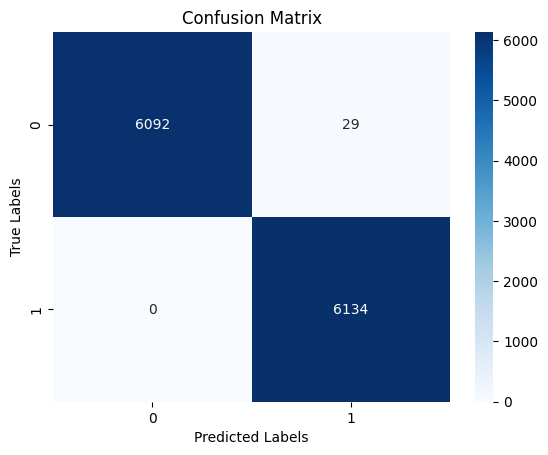

In [ ]:
xgbStrokeModel, report, matrix = xgb_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s)

# Print classification report
print("Classification Report:")
print(report)


# Print  and confusion matrix
y_pred_test = xgbStrokeModel.predict(X_test_s)

# Assuming y_pred_test contains the predicted labels and y_test_s contains the true labels
cm = confusion_matrix(y_test_s, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()

In [ ]:
# xgbStrokeModel, report, matrix = xgb_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s)
# # Save the trained model with pickle
# with open('xgbStrokeModel.pkl', 'wb') as file:
#     pickle.dump(xgbStrokeModel, file)

### Random Forest Model

In [ ]:
def rf_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s):
    # Initialize the random forest classifier
    RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

    # Define the parameter range for grid search
    param_grid = {'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]}

    # Perform grid search
    gridRF = GridSearchCV(RF, param_grid)
    gridRF.fit(X_train_s, y_train_s)

    # Predict on train and test sets
    y_pred_train = gridRF.predict(X_train_s)
    y_pred_test = gridRF.predict(X_test_s)

    # Calculate and print accuracy scores
    train_accuracy = accuracy_score(y_train_s, y_pred_train)
    test_accuracy = accuracy_score(y_test_s, y_pred_test)

    return gridRF, train_accuracy, test_accuracy

d:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

d:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

d:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

d:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.

d:\GitHub\FYP_TP055241\env\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too 

Best Parameters: {'n_estimators': 200}
Train Accuracy: 1.0
Test Accuracy: 0.997062423500612
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6121
           1       0.99      1.00      1.00      6134

    accuracy                           1.00     12255
   macro avg       1.00      1.00      1.00     12255
weighted avg       1.00      1.00      1.00     12255



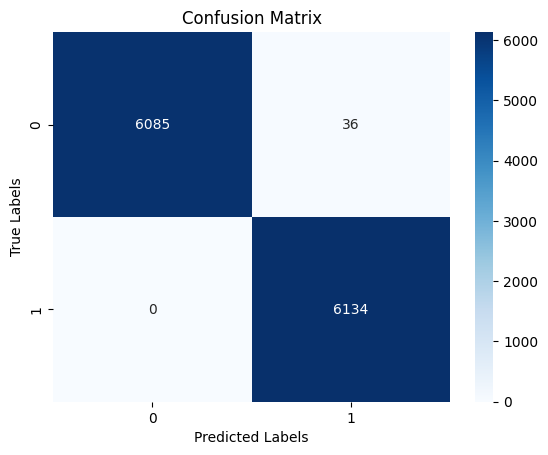

In [ ]:
rfStrokeModel, train_acc, test_acc = rf_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s)

# Print best parameters
print("Best Parameters:", rfStrokeModel.best_params_)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

# Print classification report and confusion matrix
y_pred_test = rfStrokeModel.predict(X_test_s)
print("Classification Report:")
print(classification_report(y_test_s, y_pred_test))

# Assuming y_pred_test contains the predicted labels and y_test_s contains the true labels
cm = confusion_matrix(y_test_s, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()

### Logistic Regression Model

In [ ]:
def lr_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s):
    # Initialize the logistic regression classifier
    LR = LogisticRegression(solver='liblinear', random_state=0)

    # Train the model
    LR.fit(X_train_s, y_train_s)

    # Predict on the test set
    predicted_y = LR.predict(X_test_s)

    # Evaluate the model
    report = classification_report(y_test_s, predicted_y)
    matrix = confusion_matrix(y_test_s, predicted_y)

    return LR, report, matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      6121
           1       0.70      0.62      0.66      6134

    accuracy                           0.68     12255
   macro avg       0.68      0.68      0.68     12255
weighted avg       0.68      0.68      0.68     12255



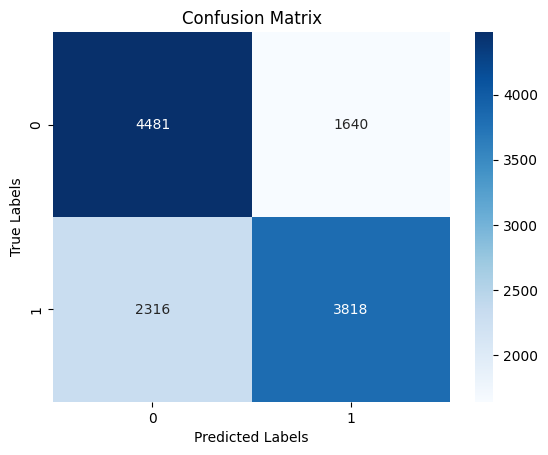

In [ ]:
lrStrokeModel, report, matrix = lr_stroke_model(X_train_s, y_train_s, X_test_s, y_test_s)

# Print the classification report
print("Classification Report:")
print(report)

# Print classification report and confusion matrix
y_pred_test = lrStrokeModel.predict(X_test_s)

# Assuming y_pred_test contains the predicted labels and y_test_s contains the true labels
cm = confusion_matrix(y_test_s, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()